# Laboratory 3: Deep Learning and Modeling Materials

We start with the prerequisites for the lab. It's always good to put this in at the beginning. 

In [1]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from scipy.sparse import spdiags,linalg,eye
from tqdm import tqdm
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Sampler, BatchSampler, Dataset, DataLoader, Subset, SubsetRandomSampler, random_split

In [2]:
#%pip install torchmetrics
from torchmetrics import Accuracy

## Project Part 1 : Ising model

No numerical physics class would be complete without doing the Ising model. Howevr, because we want to be starte of the art on this. We are going to do the Ising model in way that is a little bit different than what you have done in the past. We are going to do the Ising model with Deep learning. The first part of this project will largely follow work done in this nature paper

https://arxiv.org/abs/1605.01735 

This captures much of the core ideas that we want in building simulators, and, of course highlights the basic scheme that we get in an Ising model. 

Our first step is to setup the Ising model

### Step 1.1: The lattice Ising Model 


The Ising model is a mathematical model used to describe the behavior of a collection of interacting magnetic moments, such as atoms in a solid or spins in a lattice. The model is named after Ernst Ising, a physicist who first proposed it in 1925.

#### 1.1.1   Setting up Model

In the Ising model, each magnetic moment is represented by a spin variable, which can take on the values of +1 or -1. The model assumes that these spins interact only with their nearest neighbors in a lattice, and that the interaction between them is influenced by an external magnetic field.

The Hamiltonian of the Ising model describes the energy of the system, and is given by:

$$
H = -J \sum_{i,j} s_{i} s_{j} - \mu_{b} \sum_{j} B_{j} s_{j}
$$

where J is the exchange interaction strength between neighboring spins, $\mu$ is the magnetic moment of each spin, $B_{j}$ is the external magnetic field, and the first sum is taken over all pairs of nearest-neighbor spins in the lattice.

The Ising model exhibits a phase transition, which is a sudden change in the behavior of the system as a parameter is varied. In the absence of an external magnetic field (B=0), the model exhibits a phase transition at a critical temperature known as the Curie temperature (Tc). Below the critical temperature, the system exhibits long-range order, with all spins aligning in the same direction, resulting in a net magnetization. Above the critical temperature, the system becomes disordered, with spins pointing in random directions, and the net magnetization vanishes.

The critical behavior of the Ising model at the phase transition is described by universal scaling laws, which are independent of the microscopic details of the system. These scaling laws have been used to study a wide range of physical systems, including magnets, fluids, and even social networks.

As a first step write (split the below code into multiple steps to build the concept and guide the the student)

As an example of how we will setup the Ising model, see the initialize code. 

In [3]:
np.random.seed(20)

def initialize(N):   
    state = 2*np.random.randint(2, size=(N,N))-1
    return state

N=4
test=initialize(N)
print(test)

[[ 1 -1  1  1]
 [-1 -1  1 -1]
 [ 1 -1  1 -1]
 [-1 -1 -1  1]]


Ok, so now that we have done that let's define a Hamiltonian that will output the energy of the above grid. For this grid, we will use wrap-around (video-game) coordinates whereby the coordinate for $j+1 \forall j \geq N j+1\rightarrow j \mod N$ or in other words the in a 4x4 model the spin at x=0 y=2 can contribute to the x=3 y=2 neighbor spin the x-axis.

In [4]:
#QUESTION
def hamiltonian(iArr,N):
    energy = 0
    for i in range(N):
        for j in range(N):
            spin   = iArr[i,j]
            energy += -0.5*spin*(iArr[i,(j+1)%N] +  iArr[i,(j-1)%N] +  iArr[(i-1)%N,j] + iArr[(i+1)%N,j])
    return energy


hamiltonian(test,N)
#print energy should be 4

4.0

The above energy with the random seed should give us a value of 4. 

Now we would like to come up with a strategy to evolve the spin configurations of the Ising model. To do this we are going to follow a Markov Chain Monte-Carlo Proposal strategy.  For this write a Metropolis algorithm that 

 * Flips the spin of the i,j-th element of the grid
 * Computes $\Delta H=E_{\rm after}-E_{\rm before}$ the change in energy for that element
 * Updates the spin flip with probability $p < e^{-\frac{\Delta H}{k_{b} T} }$ 

Note that we often define temperature in the Ising model using a variable $\beta=\frac{1}{k_{b}T}$. The update need not be temperature.  Additionally, to make our units extra simple we will set the Boltzman Constant $k_{b}=1$. 

In [5]:
def flip(i,j,iArr,Beta,N):
    spin   = iArr[i,j]
    energy = 2*spin*(iArr[i,(j+1)%N] +  iArr[i,(j-1)%N] +  iArr[(i-1)%N,j] + iArr[(i+1)%N,j])
    scanrnd = np.random.uniform(size=(energy.shape))
    expval  = np.exp(-1*(energy>0)*energy*Beta)
    iArr[i,j]  *= np.where(scanrnd < expval, -1, 1)
    return

print("Before Flip:\n",test)
flip(2,1,test,1,N)
print("After Flip:\n",test)
#the 2,1 element should go from -1 to 1

Before Flip:
 [[ 1 -1  1  1]
 [-1 -1  1 -1]
 [ 1 -1  1 -1]
 [-1 -1 -1  1]]
After Flip:
 [[ 1 -1  1  1]
 [-1 -1  1 -1]
 [ 1  1  1 -1]
 [-1 -1 -1  1]]


Now define the magnetization of the system. This is just the sum over *all* the spins in the array: 

$$
M=\sum_{i\in {\rm Lattice}} \sigma_{i}
$$

Write a function to do this:

In [6]:
def mag(iArr):
    return np.sum(iArr)
print("magnetization:",mag(test))#Should be zero if you flipped 2,1 correctly, otherwise from raw is -2

magnetization: 0


Write a function that tries to flip every element in the array in random order.  Use the functions above to help you. 

In [7]:
def update_rand(iArr,N,TM1):
    # get random element order
    elts = np.random.randint(N*N, size=N*N)
    flip(elts // N, elts % N, iArr, TM1, N)
    return

In [8]:
print("Before Flip:\n",test)
update_rand(test,4,1)
print("After Flip:\n",test)

Before Flip:
 [[ 1 -1  1  1]
 [-1 -1  1 -1]
 [ 1  1  1 -1]
 [-1 -1 -1  1]]
After Flip:
 [[-1 -1 -1  1]
 [-1  1 -1  1]
 [ 1 -1 -1  1]
 [-1 -1  1 -1]]


Finally, we can put it all together by adding a plotting function that can allow us to make a viedeo of the phase transition. 

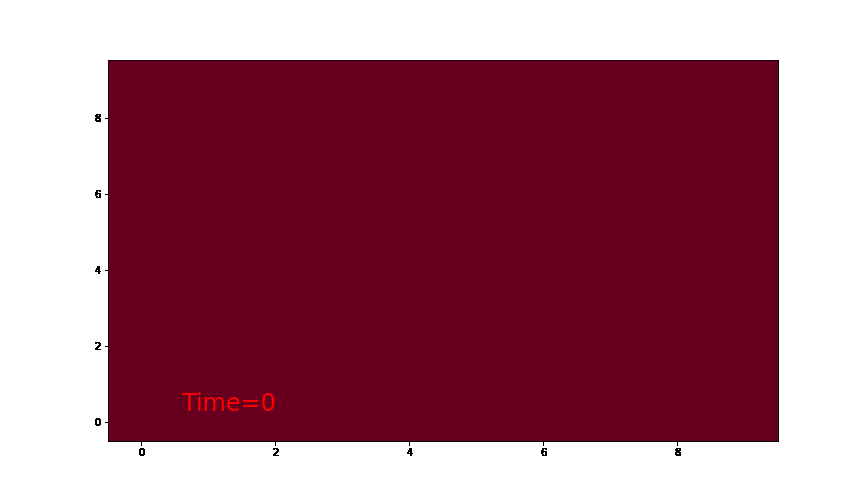

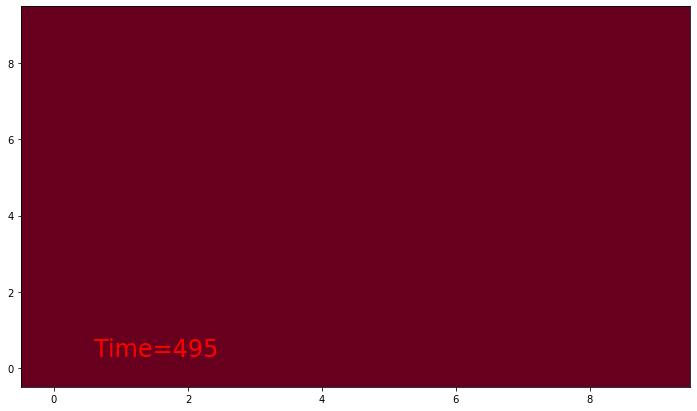

In [9]:
from IPython.display import Image

def mapPlot(ax,fig, iArr, i, N, images):
    plt.cla()
    X, Y = np.meshgrid(range(N), range(N))
    #plt.setp(sp.get_yticklabels(), visible=False)
    #plt.setp(sp.get_xticklabels(), visible=False)      
    ax.pcolormesh(X, Y, iArr, cmap=plt.cm.RdBu);
    ax.text(0.6, 0.3,'Time=%d'%i,fontdict={'size': 24, 'color':  'red'})#; plt.axis('tight')    
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image  = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)

def runTemp(iT,iN,images,fig,ax,eqSteps=500,mcSteps=500):
    pArr = initialize(iN)         # initialise
    beta=1.0/iT 
    for i in range(eqSteps):         # equilibrate
        update_rand(pArr, iN, beta)   
    
    for i in range(mcSteps):
        update_rand(pArr, iN, beta)           
        Ene = hamiltonian(pArr, iN)     # calculate the energy
        Mag = mag(pArr)        # calculate the magnetisation
        if i % 5 == 0: 
            mapPlot(ax,fig,pArr,i,iN,images)

images=[]
fig, ax = plt.subplots(figsize=(12,7))
runTemp(1.00,10,images,fig,ax)
imageio.mimsave('./test.gif', images, fps=10)
Image(open('test.gif','rb').read())

Play around with the tempature. How does the Ising model look for different tempatures? 

Do you visualize a phase transition? (if you are impatient, move on!0

#### Step 1.1.2 Modelling the Phase transition 

Now, what we would like to do for each of our simulations is compute a bunch of quantities about the matter. In particular, we would like to compute the following quantities for the Ising model: 

 * Average Energy $\langle E \rangle$ averaged over all the cells of the Ising model
 * Average Magnetization $\langle M \rangle$ averaged over all the cells of the Ising model
 * Specific Heat $C=\frac{\langle E^{2}\rangle - \langle E\rangle^{2}}{T^{2}}$ where $E$ is the cell energy averaged over all the cells of the Ising model
 * Magnetic Susceptibility $\chi=\frac{\langle M^{2}\rangle - \langle M\rangle^{2}}{T}$ where $M$ is the magnetization averaged over all of the cells in the Ising model

Now the importance of this is that we would like to scan the temperature and observe a phase transition. The specific heat,  in particular, has an infinite discontinuity in the precence of a phase trasition. 

In the below modify the function to output thse variable. 

In [10]:
def runTemp(iT,iN,images,fig,ax,eqSteps=500,mcSteps=500):
    pArr = initialize(iN)         # initialise
    #initial variables? 
    E1 = M1 = E2 = M2 = 0
    beta=1.0/iT 
    for i in range(eqSteps):         # equilibrate
        update_rand(pArr, iN, beta)   
    
    energies = []
    magnetizations = []
    
    for i in range(mcSteps):
        update_rand(pArr, iN, beta)           
        Ene = hamiltonian(pArr, iN)     # calculate the energy
        Mag = mag(pArr)        # calculate the magnetisation
        
        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag 
        E2 = E2 + Ene*Ene

    navg=1./(iN**2)
    E = (E1/mcSteps)*navg
    M = (M1/mcSteps)*navg
    C = (E2/mcSteps - (E1/mcSteps)*(E1/mcSteps))*navg*(beta**2)
    X = (M2/mcSteps - (M1/mcSteps)*(M1/mcSteps))*navg*beta
    return E,M,C,X


Now we have computed all of these things, lets go ahead and scan the temperature to see what is going on. Make a scan of temperature from $k_{b}T = 1.5$ to $3.3$. 

As you scan along plot the different values for E,M,C,$\chi$ Where do you see the phase transition? What characterizes this phase transition?

In [11]:
N=10#Something (your choice, choose wisely)
nt = 32 #Number of temperature points
T  = np.linspace(1,4,nt) #again pick
E,M,C,X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
for temp in tqdm (range (nt), desc="Loading..."):
    E[temp],M[temp],C[temp],X[temp] = runTemp(T[temp],N,images,fig,ax,eqSteps=500,mcSteps=500)


Loading...: 100%|███████████████████████████████| 32/32 [00:02<00:00, 11.77it/s]


Now, given our above simulation. Go ahead and plot the the various parameters. What do you see? (It might be worth checking this with resources)

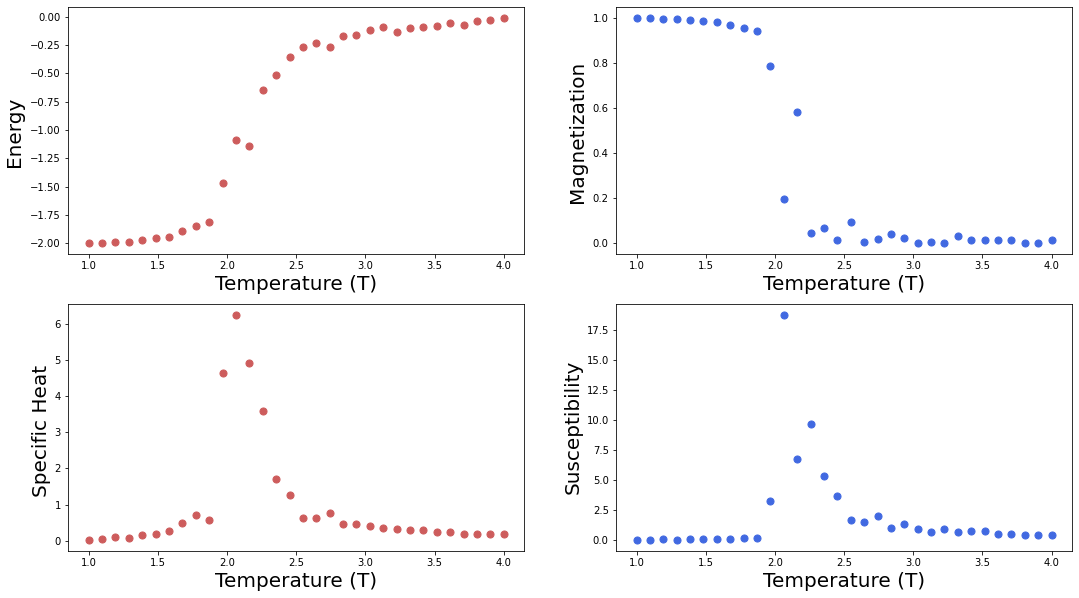

In [12]:
f = plt.figure(figsize=(18, 10)); #  

sp =  f.add_subplot(2, 2, 1 );
plt.scatter(T, E, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');


sp =  f.add_subplot(2, 2, 2 );
plt.scatter(T, abs(M), s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight');


sp =  f.add_subplot(2, 2, 3 );
plt.scatter(T, C, s=50, marker='o', color='IndianRed')
plt.xlabel("Temperature (T)", fontsize=20);  
plt.ylabel("Specific Heat ", fontsize=20);   plt.axis('tight');   


sp =  f.add_subplot(2, 2, 4 );
plt.scatter(T, X, s=50, marker='o', color='RoyalBlue')
plt.xlabel("Temperature (T)", fontsize=20); 
plt.ylabel("Susceptibility", fontsize=20);   plt.axis('tight');

From the above, it should be clear there is a critical temperature for the Ising model. Its in weird units, but we could easily conver this to a normal temperature. The other thing you can see wright away is how this material magnetizes and how it can change as a function of the different temperature regimes.

The full 2D Ising model has also been solved analytically, with a complete solution coming in the past 10 years. This was the motivation for the Fields medal in 2022 for Hugo Duminil-Copin at the University of Geneva. That being said the properties of criticallity and a simplfied solution have been known since 1950.

Can you validate that you get the right critical tempature from analytic calcualtions ($T_{c} = 2/\log(1+\sqrt{2})$)

## Step 1.2:  Constructing Ising Model Simulation

Now that we have generated an Ising model, we want to build an optimized scheme to run the Ising model many times so that we can train a neural network to understand the critical temperature of the ising model.

#### 1.2.1 Training an NN

For this part of the lab, we would like to generate Ising Monte Carlo Simulations where we randomly sample many configurations, and we the evolve the configuration at a specific temperature and then save it. Practically means we need to make simulated events where in each event, we

Randomly sample a config
Evolve that config  𝑁 steps ( 𝑁≈500 )
Save the evolved configuration, magnetization and temperature
Repeat the above nsim times and write this all to disk
Once, we have done that then we can use the datasets have generated to make a neural network that takes as input the random configuration and outputs the temperature.

So now lets make a class that generates Ising configurations. We can use use the previous functions. The important function in our class is the simulate_save, this will write a file with all of our Ising simulations.

A class setup is below for you to fill out.



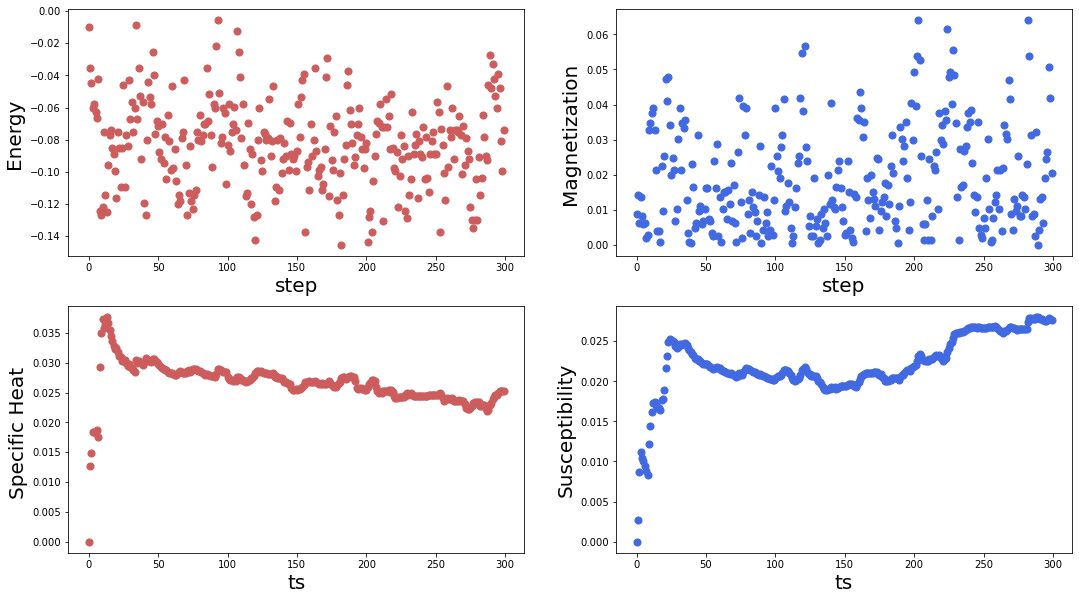

In [13]:
import h5py 

class Ising():
    
    def __init__(self, iN, Temp):
        self.N   = iN
        self.T   = Temp
        self.arr = self.initialize()
        self.steps = 300
        #History over simulatinp
        self.E   = np.array([])
        self.M   = np.array([])
        self.C   = np.array([])
        self.X   = np.array([])
        self.nsim = 1000
        
    def initialize(self):   
        #use previous function
        state = 2*np.random.randint(2, size=(self.N,self.N))-1
        return state
    
    def simulate(self):
        beta = 1./self.T
        for i in range(self.steps):
            update_rand(self.arr, self.N, beta)           
            Ene = hamiltonian(self.arr, self.N)
            Mag = mag(self.arr)
            #Now save energy magnetization 
            self.E   = np.append(self.E, Ene/(self.N**2))
            self.M   = np.append(self.M, Mag/(self.N**2))
            #Now COMPUTE specific Heat and Magnetic suscpetilibity
            #HINT, consider what the meaning of RMS of Energy and Magnetization are
            #Perhaps consider a sliding window over the last hundred steps
            pC  = np.std(self.E[-100:])
            pX  = np.std(self.M[-100:])
            self.C   = np.append(self.C,pC)
            self.X   = np.append(self.X,pX)

    def simulate_save(self,pre=''):
        h5f  = h5py.File((pre)+'data_'+str(self.T)+'.h5', 'a')
        data = np.array([])#np.empty((1,self.N,self.N), int)
        mags = np.array([])
        TM1  = 1./self.T
        for n in range(self.nsim):
            if n % 25 == 0:
                print("sim",n)
            self.initialize()
            ## Add code to run simulate the ising model nsteps
            ## update self.arr  
            for i in range(self.steps):
                update_rand(self.arr, self.N, TM1)
                
            #for each simulation we want to save the magnetization and the array  
            pMag = mag(self.arr)
            data = np.append(self.arr,data)
            mags  = np.append(pMag,mags)

        #now we write the output array into a dataset
        data = np.reshape(data,(self.nsim,self.N,self.N))
        h5f.create_dataset('data', data=data)
        h5f.create_dataset('mag' , data=mags)
        h5f.close()
                    
    def lastAvg(self):
        avgE = np.mean(self.E[500:-1])
        avgM = np.mean(self.M[500:-1])
        avgC = np.std(self.E[500:-1])
        avgX = np.std(self.M[500:-1])
        return avgE,avgM,avgC,avgX
        
    def plotEvol(self):
        ts = range(len(self.E))
        f = plt.figure(figsize=(18, 10)); #  
        sp =  f.add_subplot(2, 2, 1 );
        plt.scatter(ts, self.E, s=50, marker='o', color='IndianRed')
        plt.xlabel("step", fontsize=20);
        plt.ylabel("Energy ", fontsize=20);         plt.axis('tight');

        #PLOT THE MAGNETIZATION, SPECIFIC HEAT AND SUSCEPTIBILITY
        sp =  f.add_subplot(2, 2, 2 );
        plt.scatter(ts, abs(self.M), s=50, marker='o', color='RoyalBlue')
        plt.xlabel("step", fontsize=20); 
        plt.ylabel("Magnetization ", fontsize=20);   plt.axis('tight');

        sp =  f.add_subplot(2, 2, 3 );
        plt.scatter(ts, self.C, s=50, marker='o', color='IndianRed')
        plt.xlabel("ts", fontsize=20);  
        plt.ylabel("Specific Heat ", fontsize=20);   plt.axis('tight');   

        sp =  f.add_subplot(2, 2, 4 );
        plt.scatter(ts, self.X, s=50, marker='o', color='RoyalBlue')
        plt.xlabel("ts", fontsize=20); 
        plt.ylabel("Susceptibility", fontsize=20);   plt.axis('tight');
        
test = Ising(64,3.4)
test.simulate()
test.plotEvol()

Alright now that we have a class to run our Ising model and save things to disk we can go ahead and generate some samples following the code below, lets first generate a test sample so that we understand how to train the neural network. For this, lets just generate 10 test samples for each point, this shouldn't take too long, and will allow us to setup the neural network. 

Also, to make our ising model manageable, lets use a 32x32 Ising model. Note, feel free to change this! Second Note, this box will take a bit of time to run, its set up to do test run with 10 first, but at some point you should switch to 500.  

In [14]:
import os
nt=20
T       = np.round(np.linspace(1.53, 3.28, nt),2)
print(T)
for temp in tqdm (range (nt), desc="Loading..."):
    #Some hacky code to clean up things
    filename='data_'+str(T[temp])+'.h5'
    try:
        os.remove(filename)
    except OSError:
        pass
    test = Ising(32,T[temp])
    test.nsim=500 
    test.simulate_save()
    
f = h5py.File('data_1.53.h5', 'r') 
list(f.keys())
f['data'].shape
!ls

[1.53 1.62 1.71 1.81 1.9  1.99 2.08 2.17 2.27 2.36 2.45 2.54 2.64 2.73
 2.82 2.91 3.   3.1  3.19 3.28]


Loading...:   0%|                                        | 0/20 [00:00<?, ?it/s]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:   5%|█▌                              | 1/20 [00:09<03:06,  9.81s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  10%|███▏                            | 2/20 [00:19<02:56,  9.83s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  15%|████▊                           | 3/20 [00:29<02:47,  9.87s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  20%|██████▍                         | 4/20 [00:39<02:37,  9.87s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  25%|████████                        | 5/20 [00:49<02:28,  9.90s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  30%|█████████▌                      | 6/20 [00:59<02:19,  9.94s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  35%|███████████▏                    | 7/20 [01:09<02:10, 10.02s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  40%|████████████▊                   | 8/20 [01:20<02:01, 10.14s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  45%|██████████████▍                 | 9/20 [01:30<01:52, 10.24s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  50%|███████████████▌               | 10/20 [01:40<01:42, 10.27s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  55%|█████████████████              | 11/20 [01:51<01:32, 10.30s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  60%|██████████████████▌            | 12/20 [02:01<01:22, 10.32s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  65%|████████████████████▏          | 13/20 [02:11<01:12, 10.33s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  70%|█████████████████████▋         | 14/20 [02:22<01:02, 10.33s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  75%|███████████████████████▎       | 15/20 [02:32<00:51, 10.33s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  80%|████████████████████████▊      | 16/20 [02:43<00:42, 10.65s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  85%|██████████████████████████▎    | 17/20 [02:54<00:31, 10.55s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  90%|███████████████████████████▉   | 18/20 [03:04<00:20, 10.47s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  95%|█████████████████████████████▍ | 19/20 [03:14<00:10, 10.41s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...: 100%|███████████████████████████████| 20/20 [03:25<00:00, 10.25s/it]

8316_project3.ipynb data_2.54.h5        tridata_2.12.h5     tridata_4.69.h5
README.md           data_2.64.h5        tridata_2.32.h5     tridata_4.89.h5
data_1.53.h5        data_2.73.h5        tridata_2.52.h5     tridata_5.08.h5
data_1.62.h5        data_2.82.h5        tridata_2.71.h5     tridata_5.28.h5
data_1.71.h5        data_2.91.h5        tridata_2.91.h5     tridata_5.48.h5
data_1.81.h5        data_3.0.h5         tridata_3.11.h5     tridata_5.68.h5
data_1.9.h5         data_3.1.h5         tridata_3.31.h5     tridata_5.87.h5
data_1.99.h5        data_3.19.h5        tridata_3.5.h5      tridata_6.07.h5
data_2.08.h5        data_3.28.h5        tridata_3.7.h5      tridata_6.27.h5
data_2.17.h5        test.gif            tridata_3.9.h5      tridata_6.47.h5
data_2.27.h5        tridata_1.53.h5     tridata_4.1.h5      tridata_6.66.h5
data_2.36.h5        tridata_1.73.h5     tridata_4.29.h5     tridata_6.86.h5
data_2.45.h5        tridata_1.92.h5     tridata_4.49.h5


Now we would like to develop a neural network that will take in this dataaset and train for whether the sample has undergood a phase transition. 

Before we build the Neural Network, we are going to use Torch Dataset to process and format the data. Setting this up is a little annoying so we will just write the code for this down here, and we will provide a little example of how to read a Torch DataLoaer. 

The one part that we will leave for you to figure out is what are the right labels and how do you split up the testing and training dataset to ensure your network learns. 

In [15]:
critical_temperature = 2/np.log(1+np.sqrt(2))
critical_temperature

2.269185314213022

In [16]:
class DataSet(Dataset):
    def __init__(self, samples, labels, temps):
        super(DataSet, self).__init__()
        self.labels  = labels
        self.samples = samples
        self.temps   = temps
        if len(samples) != len(labels):
            raise ValueError(
                f"should have the same number of samples({len(samples)}) as there are labels({len(labels)})")
            
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        y = self.labels[index]
        x = self.samples[index]
        t = self.temps[index]
        return x, y, t


nones = 0
all_data  = None
all_temps = None
for temp in tqdm (range (nt), desc="Loading..."):
    f = h5py.File('data_'+str(T[temp])+'.h5', 'r')
    if temp == 0:
        all_data  = f['data']
        all_temps = np.ones(all_data.shape[0])*temp
    else:
        all_data  = np.append(all_data, f['data'],axis=0)
        all_temps = np.append(all_temps,np.ones(f['data'].shape[0])*temp)
    if T[temp] < 2.25:
        nones = all_data.shape[0]

print("N ones:",nones,all_data.shape[0])
all_data    = np.reshape(all_data,(all_data.shape[0],all_data.shape[1]*all_data.shape[2]))
all_labels  = np.append(np.ones(nones),np.zeros(all_data.shape[0]-nones)).astype("float32")
all_dataset = DataSet(samples=all_data.astype("float32"),labels=all_labels,temps=all_temps)
ntotal      = all_data.shape[0]
#Finally, we will split the dataset randomly
data_train, data_test = random_split(all_dataset, [int(0.8*ntotal),ntotal-int(0.8*ntotal)])
#And a loader
batch=10
train_loader = DataLoader(data_train, batch_size=batch,shuffle=True)
#here is an example how it works
for count, (x, y, t) in enumerate(train_loader):
    print(count,"x value:",x,x.shape,"\n Label:",y,y.shape,"\n Temp:",t,t.shape)
    if count > 2:
        break
        
print("Total Length:",len(data_train),all_data.shape,len(train_loader))

Loading...: 100%|██████████████████████████████| 20/20 [00:00<00:00, 102.02it/s]


N ones: 4000 10000
0 x value: tensor([[-1., -1.,  1.,  ...,  1., -1.,  1.],
        [-1., -1., -1.,  ...,  1., -1., -1.],
        [-1., -1.,  1.,  ..., -1.,  1.,  1.],
        ...,
        [-1.,  1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [ 1.,  1., -1.,  ...,  1., -1., -1.]]) torch.Size([10, 1024]) 
 Label: tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]) torch.Size([10]) 
 Temp: tensor([12.,  9., 12.,  9., 13., 15., 19., 16.,  1., 19.], dtype=torch.float64) torch.Size([10])
1 x value: tensor([[-1., -1.,  1.,  ...,  1.,  1., -1.],
        [ 1.,  1., -1.,  ...,  1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1.,  1.],
        ...,
        [ 1., -1., -1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1., -1.,  1.,  ...,  1.,  1.,  1.]]) torch.Size([10, 1024]) 
 Label: tensor([0., 0., 0., 1., 1., 1., 0., 1., 0., 1.]) torch.Size([10]) 
 Temp: tensor([16., 18., 10.,  0.,  1.,  6., 17.,  7., 13.,  4.], dtype=torch

Now finally, setup a neural network that reads in the inputs, and then trains to find the label. Create your own neural network that takes the input as a vector or image (note you can use a Dense network or a CNN). 

Additionally, add a loss that classifies whether the data is above or below the critical tempeature. Run the training so that we get good performance for the classification of above or below the critical temperature.

In [17]:
class simple_MLP_4layer(torch.nn.Module):
    def __init__(self,input_size,out_channels=1,nhidden=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, out_channels),
        )
        self.output  = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        x = self.output(x)
        return x

                
def train(model,n_epochs=20):
    opt       = torch.optim.Adam(model.parameters(),lr=0.005)
    criterion = torch.nn.BCELoss()
    for epoch in range(n_epochs):
        model.train(True)
        running_loss = 0.0; updates=0
        for x, y, t in train_loader:
            opt.zero_grad()
            y_hat = model(x)
            loss  = criterion(y_hat.flatten(),y) 
            loss.backward()
            opt.step()
            running_loss += loss
            updates +=1
            del x,y
        print('Epoch: {} LOSS train: {} '.format(epoch,running_loss/(updates*batch)))

model     = simple_MLP_4layer(all_data.shape[1],out_channels=1) 
train(model,n_epochs=400)

Epoch: 0 LOSS train: 0.019589658826589584 
Epoch: 1 LOSS train: 0.013272243551909924 
Epoch: 2 LOSS train: 0.008994000032544136 
Epoch: 3 LOSS train: 0.005746800452470779 
Epoch: 4 LOSS train: 0.004476509522646666 
Epoch: 5 LOSS train: 0.004454930312931538 
Epoch: 6 LOSS train: 0.0037764913868159056 
Epoch: 7 LOSS train: 0.0032353282440453768 
Epoch: 8 LOSS train: 0.0021272306330502033 
Epoch: 9 LOSS train: 0.0032033086754381657 
Epoch: 10 LOSS train: 0.00261392118409276 
Epoch: 11 LOSS train: 0.0009802731219679117 
Epoch: 12 LOSS train: 0.0009042380261234939 
Epoch: 13 LOSS train: 0.0014792728470638394 
Epoch: 14 LOSS train: 0.0035816056188195944 
Epoch: 15 LOSS train: 0.002357638441026211 
Epoch: 16 LOSS train: 0.001056696055456996 
Epoch: 17 LOSS train: 0.0006062131142243743 
Epoch: 18 LOSS train: 0.0006294628838077188 
Epoch: 19 LOSS train: 0.0019428262021392584 
Epoch: 20 LOSS train: 0.0019326112233102322 
Epoch: 21 LOSS train: 0.0026221233420073986 
Epoch: 22 LOSS train: 0.004064

Epoch: 184 LOSS train: 0.012969260104000568 
Epoch: 185 LOSS train: 0.014808567240834236 
Epoch: 186 LOSS train: 0.012553197331726551 
Epoch: 187 LOSS train: 0.02602871134877205 
Epoch: 188 LOSS train: 0.02272029221057892 
Epoch: 189 LOSS train: 0.02555658109486103 
Epoch: 190 LOSS train: 0.01698339730501175 
Epoch: 191 LOSS train: 0.02213771641254425 
Epoch: 192 LOSS train: 0.018544988706707954 
Epoch: 193 LOSS train: 0.01283364836126566 
Epoch: 194 LOSS train: 0.024508416652679443 
Epoch: 195 LOSS train: 0.025410663336515427 
Epoch: 196 LOSS train: 0.022071752697229385 
Epoch: 197 LOSS train: 0.03372382000088692 
Epoch: 198 LOSS train: 0.02995198778808117 
Epoch: 199 LOSS train: 0.02995600737631321 
Epoch: 200 LOSS train: 0.035222820937633514 
Epoch: 201 LOSS train: 0.04128027334809303 
Epoch: 202 LOSS train: 0.04255789518356323 
Epoch: 203 LOSS train: 0.0335344634950161 
Epoch: 204 LOSS train: 0.01703820377588272 
Epoch: 205 LOSS train: 0.015205780044198036 
Epoch: 206 LOSS train: 0

Epoch: 370 LOSS train: 0.1063314750790596 
Epoch: 371 LOSS train: 0.10633091628551483 
Epoch: 372 LOSS train: 0.10437395423650742 
Epoch: 373 LOSS train: 0.08671504259109497 
Epoch: 374 LOSS train: 0.15940119326114655 
Epoch: 375 LOSS train: 0.1772991418838501 
Epoch: 376 LOSS train: 0.07843591272830963 
Epoch: 377 LOSS train: 0.08702180534601212 
Epoch: 378 LOSS train: 0.0936429426074028 
Epoch: 379 LOSS train: 0.09629501402378082 
Epoch: 380 LOSS train: 0.09629454463720322 
Epoch: 381 LOSS train: 0.11072075366973877 
Epoch: 382 LOSS train: 0.13849937915802002 
Epoch: 383 LOSS train: 0.13892918825149536 
Epoch: 384 LOSS train: 0.13892444968223572 
Epoch: 385 LOSS train: 0.1389230489730835 
Epoch: 386 LOSS train: 0.1389228105545044 
Epoch: 387 LOSS train: 0.13892118632793427 
Epoch: 388 LOSS train: 0.13892176747322083 
Epoch: 389 LOSS train: 0.13892169296741486 
Epoch: 390 LOSS train: 0.13892196118831635 
Epoch: 391 LOSS train: 0.13892154395580292 
Epoch: 392 LOSS train: 0.138922244310

Now run the validation and confirm that temperature prediction of the neural network. Plot the true value of the vadliation set agains the prediction. How clos is the preidction? What is the accuracy

Accuracy: tensor(0.9856)


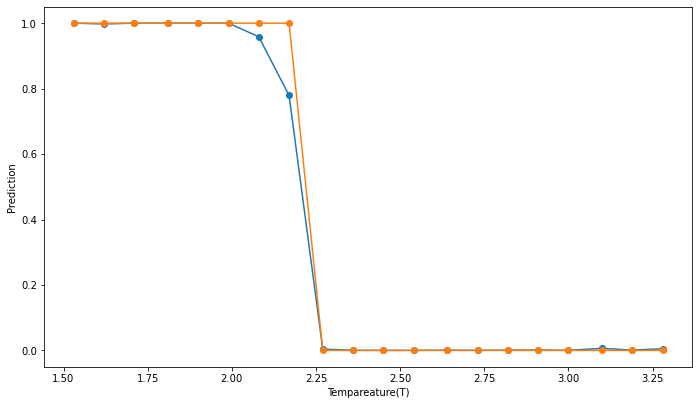

In [18]:
model.train(False)
test_accuracy = Accuracy(task="binary", num_classes=2)
tplot  = np.array([])
yplot  = np.zeros(len(T))
ytrue  = np.zeros(len(T))
ycount = np.zeros(len(T))
ypred  = np.array([])
yact   = np.array([])
for x, y, t in train_loader:
    with torch.no_grad():
        y_hat = model(x)
        ypred = np.append(ypred,y_hat)
        yact = np.append(yact,y)
        #tplot = np.append(tplot,t)
        for pT,py_hat,py in zip(t.detach().numpy(),y_hat.detach().numpy(),y.detach().numpy()):
            pT = int(pT)
            yplot[pT]  += py_hat[0]
            ytrue[pT]  += py
            ycount[pT] += 1
            
target = torch.tensor(ypred)
preds  = torch.tensor(yact)
print("Accuracy:",test_accuracy(target,preds))
yplot/=ycount
ytrue/=ycount
f = plt.figure(figsize=(9, 5));
f.add_axes([0,0,1,1])#matplotlib.pyplot.figure()
plt.plot(T,yplot, marker='o')
plt.plot(T,ytrue, marker='o')
plt.ylabel('Prediction')
plt.xlabel('Tempareature(T)')
plt.show()

#### 1.2.2 NN application on Triangle Ising Model

Ok, so once our validation is looking good, we want to show are neural network has actually learned something non-trivial for that we want to make a different Magnetic fild configuration with a different, but similar Hamiltonian, and see if we can us our neural network to predict the temuprature change. 

As a consequence, write a function for the Hamiltonian of the Triangular Ising model. We can define the triangular Ising model as a trigualr array as oppose to a square array like in the picture below fore [here](https://link.springer.com/article/10.1134/S1063776122050016)
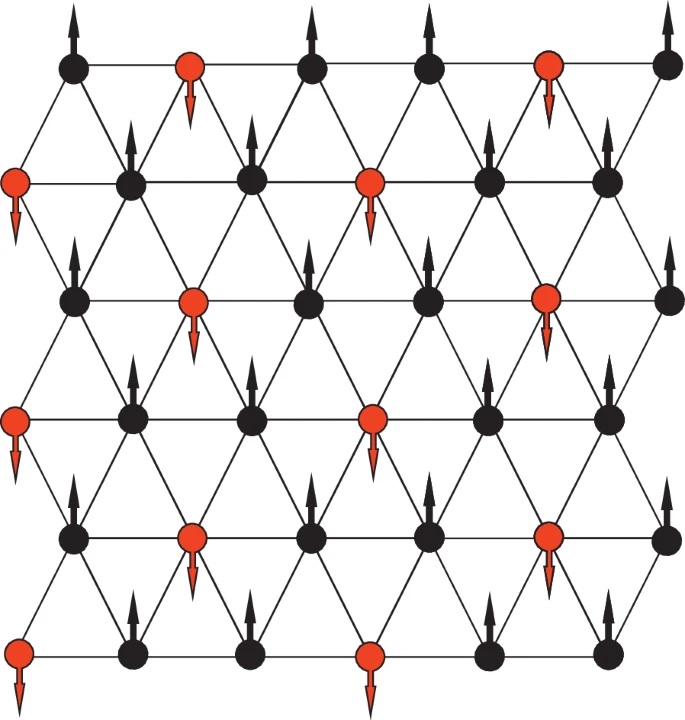

The Hamiltonian is again the Ising Hamiltonian except now we sum over all 6 elements $i,j$ connected to a point. 
$$
H = -\frac{1}{2}\sum_{i,j\in{adjacent to i}} \sigma_{i}\sigma_{j} - h \sum_{i} \sigma_{i}
$$

Just fousing on teh first term, write a Hamiltonian that will act on an N$\times$N array following a pattern above  to create the triangular array. We can again use a video game Geometry to make this easier. Connect one end to the other. 


In [22]:
#Now lets define the trignular ising 
def hamiltonian(iArr,N):
    #Compute the hamiltonian (note if you use this function you don't need to redeclare the above class)
    energy = 0
    for i in range(N):
        for j in range(N):
            spin = iArr[i,j]
            shift  = (j-1) % 2 
            energy += -0.5*spin*(iArr[(i-1)%N, j ] +  iArr[(i+1)%N,j])
            energy += -0.5*spin*(iArr[(i-1+shift)%N, (j+1) % N ] + iArr[(i+shift)%N, (j+1) % N])
            energy += -0.5*spin*(iArr[(i-1+shift)%N, (j-1) % N ] + iArr[(i+shift)%N, (j-1) % N])
     
    return energy

def flip(i,j,iArr,beta,N):
    spin   = iArr[i,j]
    shift  = (j-1) % 2 
    energy = 2*spin*(iArr[(i-1)%N, j ] +  iArr[(i+1)%N,j] + iArr[(i-1+shift)%N, (j+1) % N ] + iArr[(i+shift)%N, (j+1) % N]  + iArr[(i-1+shift)%N, (j-1) % N ] + iArr[(i+shift)%N, (j-1) % N])
    scanrnd = np.random.uniform(size=(energy.shape))
    expval  = np.exp(-1*(energy>0)*energy*beta)
    iArr[i,j]  *= np.where(scanrnd < expval, -1, 1)
    #finally run the Markov Chain process that computes delta energy, and based on the Markov deicison flips the spins. 

#Run some checks? 

Finally, run the neural entwork on a dataset for triangular Ising models. Show that you can predict the correct tempearture, what is it? 

In [23]:
nt = 28
T = np.round(np.linspace(1.53, 6.86, 28),2);
for temp in tqdm (range(nt), desc="Loading..."):
    filename='tridata_'+str(T[temp])+'.h5'
    try:
        os.remove(filename)
    except OSError:
        pass
    test = Ising(32,T[temp])
    test.nsim=500
    test.simulate_save('tri')

Loading...:   0%|                                        | 0/28 [00:00<?, ?it/s]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:   4%|█▏                              | 1/28 [00:14<06:18, 14.04s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:   7%|██▎                             | 2/28 [00:28<06:05, 14.05s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  11%|███▍                            | 3/28 [00:42<05:51, 14.05s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  14%|████▌                           | 4/28 [00:56<05:37, 14.07s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  18%|█████▋                          | 5/28 [01:10<05:23, 14.09s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  21%|██████▊                         | 6/28 [01:24<05:10, 14.12s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  25%|████████                        | 7/28 [01:38<04:56, 14.13s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  29%|█████████▏                      | 8/28 [01:52<04:42, 14.13s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  32%|██████████▎                     | 9/28 [02:07<04:29, 14.19s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  36%|███████████                    | 10/28 [02:21<04:15, 14.17s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  39%|████████████▏                  | 11/28 [02:35<04:00, 14.17s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  43%|█████████████▎                 | 12/28 [02:49<03:47, 14.22s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  46%|██████████████▍                | 13/28 [03:04<03:34, 14.30s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  50%|███████████████▌               | 14/28 [03:18<03:21, 14.37s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  54%|████████████████▌              | 15/28 [03:33<03:07, 14.44s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  57%|█████████████████▋             | 16/28 [03:48<02:54, 14.50s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  61%|██████████████████▊            | 17/28 [04:02<02:39, 14.51s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  64%|███████████████████▉           | 18/28 [04:17<02:25, 14.52s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  68%|█████████████████████          | 19/28 [04:31<02:11, 14.61s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  71%|██████████████████████▏        | 20/28 [04:46<01:56, 14.62s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  75%|███████████████████████▎       | 21/28 [05:01<01:42, 14.58s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  79%|████████████████████████▎      | 22/28 [05:15<01:27, 14.56s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  82%|█████████████████████████▍     | 23/28 [05:30<01:12, 14.53s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  86%|██████████████████████████▌    | 24/28 [05:44<00:58, 14.51s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  89%|███████████████████████████▋   | 25/28 [05:58<00:43, 14.50s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  93%|████████████████████████████▊  | 26/28 [06:13<00:28, 14.48s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...:  96%|█████████████████████████████▉ | 27/28 [06:27<00:14, 14.47s/it]

sim 0
sim 25
sim 50
sim 75
sim 100
sim 125
sim 150
sim 175
sim 200
sim 225
sim 250
sim 275
sim 300
sim 325
sim 350
sim 375
sim 400
sim 425
sim 450
sim 475


Loading...: 100%|███████████████████████████████| 28/28 [06:42<00:00, 14.37s/it]


Finally, run the neural network on a dataset for triangular Ising models. Show that you can predict the correct tempearture, what is it? 

Loading...: 100%|███████████████████████████████| 28/28 [00:00<00:00, 91.73it/s]


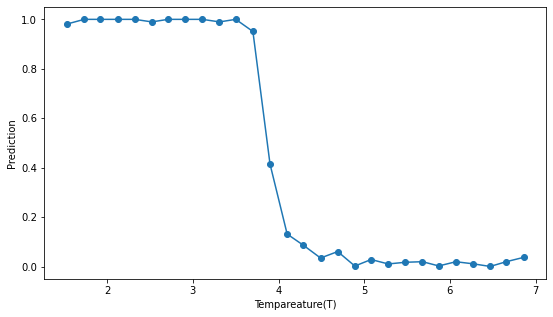

In [24]:
#Now lets test it on something different
def load():
    nones = 0
    all_tri_data  = None
    all_tri_temps = None
    for temp in tqdm (range(nt), desc="Loading..."):
        f = h5py.File('tridata_'+str(T[temp])+'.h5', 'r')
        if temp == 0:
            all_tri_data  = f['data']
            all_tri_temps = np.ones(all_tri_data.shape[0])*temp
        else:
            all_tri_data  = np.append(all_tri_data, f['data'],axis=0)
            all_tri_temps = np.append(all_tri_temps,np.ones(f['data'].shape[0])*temp)
    
    all_tri_data  = np.reshape(all_tri_data,(all_tri_data.shape[0],all_tri_data.shape[1]*all_tri_data.shape[2]))
    all_tri_labels=np.append(np.ones(nones),np.zeros(all_tri_data.shape[0]-nones)).astype("float32")
    all_tri_dataset = DataSet(samples=all_tri_data.astype("float32"),labels=all_tri_labels,temps=all_tri_temps)
    ntotal = all_tri_data.shape[0]
    data_tri_train, data_tri_test = random_split(all_tri_dataset, [int(0.8*ntotal),ntotal-int(0.8*ntotal)])
    return data_tri_train, data_tri_test

data_tri_train, data_tri_test = load()
batch=1000
test_tri_loader = DataLoader(data_tri_test, batch_size=batch,shuffle=True)

#again following above, plot the temp applying your prevoiusly trained NN to the triagle boltzman
tplot  = np.array([])
yplot  = np.zeros(len(T))
ytrue  = np.zeros(len(T))
ycount = np.zeros(len(T))
for x, y, t in test_tri_loader:
    with torch.no_grad():
        y_hat = model(x)
        for pT,py_hat,py in zip(t.detach().numpy(),y_hat.detach().numpy(),y.detach().numpy()):
            pT = int(pT)
            yplot[pT]  += py_hat[0]
            ytrue[pT]  += py
            ycount[pT] += 1
yplot/=ycount
ytrue/=ycount

#What is accuracy?     
#plot Score vs Temp where is the phase transition, is it consistent with truth see arxiv paper
f = plt.figure(figsize=(9, 5));
plt.plot(T,yplot, marker='o')
plt.ylabel('Prediction')
plt.xlabel('Tempareature(T)')
plt.show()



Ok, so we should now have a result, and you can see hwo this behaves. From this we can ask a few questions:  
 * Do you see a phase transition?  
 * Does this agree with the paper? 
 * What can you do to make this more accurate?
 
Now there are many follow ups to this study. However, I would like to highlight that he big gains that come from thsi are not the network itself, its more that the NN has been able to do a visual inspection of a material and made conclusions that are not necessarily obvious. Using this can lead to better analysis of data. Moreover, we can ask ourselves the question if we can accurately predict properties of materials can we use this to advance our understanding. 

In the following section, we will explore how we can use Machine learned distributions to rapdily accelerate simulation allow us to perform advanced lattice measurements leading to critical material properties. 

**Answer**
- There is very obviously a phase transition near $T = 3.8$. I can tell this from the plot generated above because it is nearly identical to the diagram we generated for the Ising model on the square lattice, and has the same interpretation; this network predicts whether a configuration is above or below some critical temperature $T_c$ where a phase transition occurs. 
- According to the paper, the critical temperature that I found seems reasonable, up to a factor relating to units. The paper discusses a similar observation that phase transitions occur for various values of magnetic field $B$ and temperature $T$. I am not familiar enough with the theory to convert the critical temperature I've found to the one observed in the paper.
- To make this network more accurate, I would generate larger amounts of training and test-set data to aid with model expressivity. This could include generating more sample configurations at the same temperature, but also making the grid of temperatures over which I generate sample data finer. In future iterations of this work, I would also explore additional neural network architectures that could better capture behavior in each spin configurations; in particular, a convolutional neural network would be interesting given that the lattice has clear translational symmetry.

# Part 2: Scalar field theory on a lattice

In this part of the tutorial, we will explore the methods of lattice Quantum Chromodynamics. Quantum Chromodynamics is the theory that describes the strong interaction between quarks and gluons, which are fundamental particles that make up mesons and hadrons. These particles constitute the majority of visible matter in the Universe. QCD is a crucial component of the Standard Model (SM) and is used to investigate physical phenomena such as the anomalous magnetic moment of the muon and the interactions of Dark Matter with Nuclei.

Due to its large coupling constant, QCD cannot be studied using perturbation theory. Well-established non-perturbative method, lattice QCD enables computations of physical observables though numerical simulations. Some of the most famous results obtained with lattice QCD are the study of quark potential, hadron spectrum, and hadron structure.

In this part of the tutorial, we will focus on the toy lattice QCD model - the lattice scalar field theory. Despite being the simplest interacting theory, it is also one of the most effective theoretical tools for studying critical phenomena in a wide variety of physical systems. Additionally, the Higgs field in the SM is a scalar field that breaks the weak isospin symmetry of the electroweak interaction and generates mass to many particles.

Instead of using the traditional lattice QCD approach, we will explore recent developments in machine learning. This method has already been applied to some toy models and has demonstrated its effectiveness by significantly reducing the uncertainties of physical observables by several orders of magnitude while guaranteeing correctness [arXiv:2003.06413, arXiv:2202.11712].

### Similarities between Scalar field theory and Ising Model

The Ising model and scalar field theory are seemingly different models at the microscopic level, but they share some fundamental properties that make them belong to the same universality class.

One of the key similarities is the global symmetry $Z_2$, which is the symmetry of the Ising model with respect to the flipping of all spins. In scalar field theory, this symmetry corresponds to the invariance of the Lagrangian under the transformation $\phi \rightarrow -\phi$, where $\phi$ is the scalar field.

Another important property shared by the two models is that they both undergo a phase transition at a critical temperature or coupling strength, respectively. At this critical point, the correlation length diverges, and the system exhibits scaling behavior that is independent of the microscopic details of the system.

This scaling behavior is described by critical exponents, which characterize the power-law behavior of various physical observables near the critical point. These critical exponents are universal, meaning that they are the same for all models in the same universality class, regardless of the specific microscopic details.

In summary, while the Ising model and scalar field theory may be very different at the microscopic level, they share some fundamental properties that make them belong to the same universality class. This universality allows us to study and understand the critical behavior of these models without needing to know their microscopic details, but only their macroscopic properties.


## Intro to LQCD

In lattice QCD the concept of continuous space-time is replaced with a 4D Euclidean lattice that has a constant lattice spacing denoted as $a$. The degrees of freedom in lattice QCD are classical field variables (rather than operators) that reside on the lattice. The Euclidean action $S_E$ of the system is discretized on the lattice such that in the limit $a → 0$ the Euclidean continuum action is obtained. The Boltzmann weight factor $e ^{S_E}$ is used in subsequent computations. In order to study Euclidean correlators, the operators that appear in them are replaced by functionals that use the classical lattice field variables. The computation of Euclidean correlation functions in lattice QCD involves evaluating these functionals on a given lattice field configuration, weighting them with the Boltzmann factor, and integrating over all possible field configurations. We will mimic the whole approach in this tutorial.

### Helper functions

Let's begin by defining some useful helper functions before diving into the interesting stuff.

In [22]:
def torch_mod(x):
    return torch.remainder(x, 2*np.pi)
def torch_wrap(x):
    return torch_mod(x+np.pi) - np.pi
def grab(var):
    return var.detach().cpu().numpy()

def print_metrics(history, avg_last_N_epochs):
    print(f'== Era {era} | Epoch {epoch} metrics ==')
    for key, val in history.items():
        avgd = np.mean(val[-avg_last_N_epochs:])
        print(f'\t{key} {avgd:g}')
def moving_average(x, window=10):
    if len(x) < window:
        return np.mean(x, keepdims=True)
    else:
        return np.convolve(x, np.ones(window), 'valid') / window


We have also defined some functions for creating visually appealing plots. You may skip this part if you wish.

In [23]:
def init_live_plot(dpi=125, figsize=(8,4)):
    fig, ax_ess = plt.subplots(1,1, dpi=dpi, figsize=figsize)
    plt.xlim(0, N_era*N_epoch)
    plt.ylim(0, 1)
    ess_line = plt.plot([0],[0], alpha=0.5) # dummy
    plt.grid(False)
    plt.ylabel('ESS')
    ax_loss = ax_ess.twinx()
    loss_line = plt.plot([0],[0], alpha=0.5, c='orange') # dummy
    plt.grid(False)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    display_id = display(fig, display_id=True)
    return dict(
        fig=fig, ax_ess=ax_ess, ax_loss=ax_loss,
        ess_line=ess_line, loss_line=loss_line,
        display_id=display_id
    )
def update_plots(history, fig, ax_ess, ax_loss, ess_line, loss_line, display_id):
    Y = np.array(history['ess'])
    Y = moving_average(Y, window=15)
    ess_line[0].set_ydata(Y)
    ess_line[0].set_xdata(np.arange(len(Y)))
    Y = history['loss']
    Y = moving_average(Y, window=15)
    loss_line[0].set_ydata(np.array(Y))
    loss_line[0].set_xdata(np.arange(len(Y)))
    ax_loss.relim()
    ax_loss.autoscale_view()
    fig.canvas.draw()
    display_id.update(fig) # need to force colab to update plot

PyTorch is a flexible machine learning framework that enables the construction of complex neural networks. However, for this particular project, we will only be using two-dimensional convolutional neural networks with varying configurations. The code below defines a fabric function that constructs a CNN with user-specified parameters.

In [24]:
def make_conv_net(*, hidden_sizes, kernel_size, in_channels, out_channels):
    sizes = [in_channels] + hidden_sizes + [out_channels]
    #assert packaging.version.parse(torch.__version__) >= packaging.version.parse('1.5.0')
    assert kernel_size % 2 == 1, 'kernel size must be odd for PyTorch >= 1.5.0'
    padding_size = (kernel_size // 2)
    net = []
    for i in range(len(sizes) - 1):
        net.append(torch.nn.Conv2d(
            sizes[i], sizes[i+1], kernel_size, padding=padding_size,
            stride=1, padding_mode='circular'))
        if i != len(sizes) - 2:
            net.append(torch.nn.LeakyReLU())
        else:
            net.append(torch.nn.Tanh())
    return torch.nn.Sequential(*net)

As an example, we can use the following code to build a CNN with 2 hidden channels of size 8, a kernel size of 3, and 2 input channels and 4 output channels:

In [25]:
m = make_conv_net(
    hidden_sizes=[8,8],
    kernel_size=3,
    in_channels=2,
    out_channels=4
)
print(m)

Sequential(
  (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (5): Tanh()
)


## Scalar field theory on the lattice

$\newcommand{\n}[0]{\vec{n}}$
A simple discretization of the derivatives in the continuum Euclidean action gives rise to a valid lattice Euclidean action,
\begin{equation}
\begin{split}
S^E_{\text{cont}}[\phi] &= \int d^2\vec{x} ~ (\partial_\mu \phi(\vec{x}))^2 + m^2 \phi(\vec{x})^2 + \lambda \phi(\vec{x})^4 \\
\rightarrow S^E_{\text{latt}}(\phi) &= \sum_{\n} \phi(\n) \sum_{\mu \in \{1,2\}}  \left[ 2\phi(\n) - \phi(\n+\hat{\mu}) - \phi(\n-\hat{\mu}) \right] + m^2 \phi(\n)^2 + \lambda \phi(\n)^4 \qquad (1)
\end{split}
\end{equation}
where now $\phi(\n)$ is only defined on the sites of the $L_x \times L_y$ lattice, $\vec{n} = (n_x, n_y)$, with integer $n_x, n_y$, and $\hat{\mu}$ is an operator such that $\hat{0} = (1, 0),\hat{1} = (0, 1)$. We have implicitly moved to "lattice units" where $a=1$ such that $L_x, L_y, V$ are integers and all quantities are unitless. The discretized field $\phi$ can therefore be thought of as an $(L_x \times L_y)$-dimensional vector. We use periodic boundary conditions in all directions, i.e. $\phi(L_x, y) \equiv \phi(0, y)$, etc. For convenience, we typically abbreviate $S^E_{\text{latt}} \equiv S$.

More details on $\phi^4$ lattice scalar field theory can be found in [this PhD thesis](https://edoc.hu-berlin.de/bitstream/handle/18452/14790/schroeder.pdf?sequence=1) from Ingmar Vierhaus.

### Ising limit

The action for scalar field theory defined above can be rewritten in a following form
\begin{equation}
\begin{split}
S^E_{\text{latt}}(\phi) &= \sum_{\n} -2 \kappa \sum_{\mu \in \{1,2\}} \phi(\n) \phi(\n+\hat{\mu}) + \phi(\n)^2 + \lambda' (\phi(\n)^2 - 1)^2 + constant \qquad (2)
\end{split}
\end{equation}

The Ising limit of scalar field theory is obtained by taking the limit $\lambda \rightarrow \infty$. In this limit, the scalar field is constrained to take values only in the set ${\pm 1}$, since any other value would result in an infinite potential energy contribution to the action.

To see why this is the case, consider the potential energy term in the action:

\begin{equation}
V(\phi) = \lambda'(\phi^2 - 1)^2
\end{equation}

For large $\lambda$, this potential energy term dominates over the kinetic energy term, and the field $\phi$ will tend to minimize the potential energy by taking values as close to $\pm 1$ as possible.

Substituting $\phi(\n) = \pm 1$ into the action for scalar field theory, we get:

\begin{equation}
\begin{split}
S^E_{\text{latt}}(\phi) &= \sum_{\n} -2 \kappa \sum_{\mu \in {1,2}} \phi(\n) \phi(\n+\hat{\mu}) + constant
\end{split}
\end{equation}

This is precisely the action for the two-dimensional Ising model on a lattice with coupling constant $J = 2\kappa$.

### **Exercise: rescaling bare parameters**

Although we will be using form $(1)$ of the action in our work, form $(2)$ is more commonly used in literature. In this exercise, you will need to find the relationships between the parameters $(m,\lambda)$ in eq. $(1)$ and the parameters $(\kappa,\lambda)$ in eq. $(2)$.



Answer:
$$
m^2 = \frac{1-2\lambda'}{\kappa} - 4, \, \lambda = \frac{\lambda'}{\kappa ^2}
$$

The class below implements action $(1)$. Each instance of the class is a function $S$ with fixed $m^2$, $\lambda$.

In [26]:
class ScalarPhi4Action:
    def __init__(self, M2, lam):
        self.M2 = M2
        self.lam = lam
    def __call__(self, phi):
        action_density = torch.zeros_like(phi)
        
        # potential term
        action_density += self.M2*phi**2
        action_density += self.lam*phi**4
        
        # kinetic term (discrete Laplacian)
        Nd = len(phi.shape)-1
        dims = range(1,Nd+1)
        for mu in dims:
            action_density += 2*phi**2
            action_density -= phi*torch.roll(phi, -1, mu)
            action_density -= phi*torch.roll(phi, 1, mu)
        return torch.sum(action_density, dim=tuple(dims))

Let us return to the idea of the phase transitions in these models. Just as the Ising Model exhibits an ordered phase below the critical temperature and a disordered one above, the scalar field theory has a symmetric phase and a broken symmetry phase.
For simplicity, we restrict focus to the **symmetric phase**. The cell below instantiates an action for a set of parameters in this phase.

In [27]:
M2 = -4.0
lam = 8.0

phi4_action = ScalarPhi4Action(M2=M2, lam=lam)

## Normalizing flows

The lattice action defines the _target distribution_ $p$ over configurations $\phi$,
\begin{equation}
p(\phi) = \frac{1}{Z} e^{-S(\phi)}, \quad
Z \equiv \int \prod_{\vec{n}} d\phi(\vec{n}) ~ e^{-S(\phi)},
\end{equation}
where $\prod_{\vec{n}}$ runs over all lattice sites $\vec{n}$.
Typically one uses algorithms like Hybrid Monte Carlo (HMC) to generate configurations from this distribution.

Instead, a powerful method to generate samples from complicated distributions is to: 
1. draw samples $z$ from a simple distribution $r(z)$ (the _prior distribution_), then
2. apply a deterministic change-of-variables $f$ (a _normalizing flow_ (NF)) to get transformed samples $\phi = f(z)$.

The prior $r$ and flow $f$ together define a _normalizing flow model_. Note that in this example, $z$ and $\phi$ are both scalar fields.

The transformed samples $\phi$ are distributed according to the _model distribution_, $q$, whose density is given by the change-of-variables (or "conservation of probability") formula,

\begin{equation}
    q(\phi) = r(z) [J(z)]^{-1} = r(z) \left|\det_{kl} \frac{\partial f_k(z)}{ \partial z_l} \right|^{-1} .
\end{equation}


$f$ must be **invertible** and **differentiable** for $q(\phi)$ to be well-defined. For the model to be useful, $f$ must be expressive and the Jacobian determinant factor $J(z)$ must be efficient to calculate. As you'll see below, in some cases it is easy to compute $J$ even when the whole Jacobian matrix is intractable. 

<!-- Below we construct _coupling layers_ where only the diagonal elements are needed, because the Jacobian matrix is known to be triangular. -->




### **A simple example**
The Box-Muller transform is an example of this trick in practice: to produce Gaussian random variables, draw two variables $U_1$ and $U_2$ from $\text{unif}(0,1)$ then change variables to

\begin{equation}
    Z_1 = \sqrt{-2 \ln{U_1}} \cos(2\pi U_2)
    \quad \text{and} \quad
    Z_2 = \sqrt{-2 \ln{U_1}} \sin(2\pi U_2).
\end{equation}

The resulting variables $Z_1, Z_2$ are then distributed according to an uncorrelated, unit-variance Gaussian distribution.


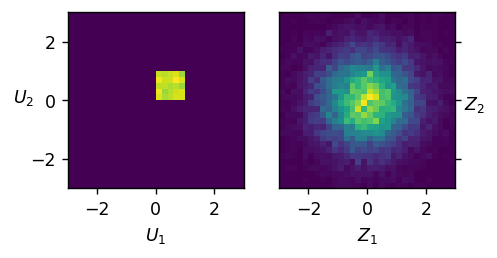

In [28]:
batch_size = 2**14
u = np.random.random(size=(batch_size, 2))
z = np.sqrt(-2*np.log(u[:,0]))[:,np.newaxis] * np.stack(
    (np.cos(2*np.pi*u[:,1]), np.sin(2*np.pi*u[:,1])), axis=-1)

fig, ax = plt.subplots(1,2, dpi=125, figsize=(4,2))
for a in ax:
    a.set_xticks([-2, 0, 2])
    a.set_yticks([-2, 0, 2])
    a.set_aspect('equal')
ax[0].hist2d(u[:,0], u[:,1], bins=30, range=[[-3.0,3.0], [-3.0,3.0]])
ax[0].set_xlabel(r"$U_1$")
ax[0].set_ylabel(r"$U_2$", rotation=0, y=.46)
ax[1].hist2d(z[:,0], z[:,1], bins=30, range=[[-3.0,3.0], [-3.0,3.0]])
ax[1].set_yticklabels([])
ax[1].set_xlabel(r"$Z_1$")
ax[1].set_ylabel(r"$Z_2$", rotation=0, y=.53)
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
plt.show()


We can analytically compute the density associated with output samples by the **change-of-variables formula** relating the _prior density_ $r(U_1, U_2) = 1$ to the _output density_ $q(Z_1, Z_2)$:

\begin{equation}
\begin{split}
    q(Z_1, Z_2) &= r(U_1, U_2) \left| \det_{kl} \frac{\partial Z_k(U_1, U_2)}{\partial U_l} \right|^{-1} \\
    &= 1 \times \left| \det \left( \begin{matrix}
        \frac{-1}{U_1 \sqrt{-2 \ln{U_1}}} \cos(2\pi U_2) &
        - 2\pi \sqrt{-2 \ln{U_1}} \sin(2\pi U_2) \\
        \frac{-1}{U_1 \sqrt{-2 \ln{U_1}}} \sin(2\pi U_2) &
        2\pi \sqrt{-2 \ln{U_1}} \cos(2\pi U_2)
        \end{matrix} \right) \right|^{-1} \\
    &= \left| \frac{2 \pi}{U_1} \right|^{-1}.
\end{split}
\end{equation}

Here, the term $J(U_1, U_2) \equiv \left| \det_{kl} \frac{\partial Z_k(U_1, U_2)}{\partial U_l} \right|$ is the determinant of the Jacobian of the transformation from $(U_1,U_2)$ to $(Z_1,Z_2)$. Intuitively, the Jacobian factor can be thought of as a change in volume element, therefore the change-of-variables formula must contain the inverse of this factor (spreading out volume decreases density). To complete the example, we can rearrange the change of variables to find $U_1 = \exp(-(Z_1^2 + Z_2^2) / 2)$ and therefore
\begin{equation}
    q(Z_1, Z_2) = \frac{1}{2\pi} e^{-(Z_1^2 + Z_2^2)/2}.
\end{equation}

**NOTE**: In this example, the model has no free parameters because we didn't need any to create a transform that exactly reproduced our target distribution (independent, unit-variance Gaussian). In general, we may not know a normalizing flow that exactly produces our desired distribution, and so instead construct parametrized models that we can variationally optimize to _approximate_ that target distribution, and because we can compute the density these can be corrected to nevertheless guarantee exactness.

### **Prior distribution**

We choose the prior distribution to be independent and identically distributed Gaussians at each lattice site, with unit width and mean zero. This is easy to sample from, and intuitively gives a "blank slate" for $f$ to build correlations into.

The cell below defines a class for this prior (which is really just a wrapper for PyTorch's normal distribution sampler), and shows how to instantiate it for lattice volume $L^2$.

You will notice that in addition to just setting up a normal and sampling, we explicitly comput the log-likelihood (aka log probability). This strategy helps with the expressiveness and tells torch that this is differentiable. 

In [29]:
class SimpleNormal:
    def __init__(self, loc, var):
        self.dist = torch.distributions.normal.Normal(
            torch.flatten(loc), torch.flatten(var))
        self.shape = loc.shape
    def log_prob(self, x):
        logp = self.dist.log_prob(x.reshape(x.shape[0], -1))
        return torch.sum(logp, dim=1)
    def sample_n(self, batch_size):
        x = self.dist.sample((batch_size,))
        return x.reshape(batch_size, *self.shape)
    
Lt, Lx = 8, 16
lattice_shape = (Lt,Lx)
prior = SimpleNormal(torch.zeros(lattice_shape), torch.ones(lattice_shape))
print("Example:",prior.sample_n(1).shape)
print("Example values: \n",prior.sample_n(1))

Example: torch.Size([1, 8, 16])
Example values: 
 tensor([[[ 1.8648e+00, -1.1608e-01,  1.2536e+00,  8.4086e-01,  2.4381e-03,
           1.6218e+00, -4.1084e-01,  1.3262e+00, -1.4277e+00, -3.8530e-01,
          -9.8546e-01, -9.6139e-01,  1.7273e-01,  5.3004e-01, -7.4330e-01,
          -6.0272e-01],
         [-3.0397e-01,  3.8118e-01,  6.0653e-01, -3.5239e-01,  8.0194e-01,
           9.3635e-01,  3.7664e-01, -1.1759e+00,  2.1760e-01, -1.1185e+00,
           1.3869e-02, -6.9666e-01, -3.5345e-01,  3.1256e-01, -4.1066e-01,
           2.3119e-01],
         [ 1.2637e+00,  3.8210e-01,  9.7794e-01, -8.3627e-02, -1.5289e+00,
           7.2643e-01, -6.6402e-01, -8.5664e-01, -1.2759e+00, -1.8771e+00,
           4.5863e-01,  5.2735e-01, -4.9410e-01, -1.4226e+00, -1.1676e+00,
           1.3325e+00],
         [ 4.2978e-01,  1.7253e+00,  4.7335e-01,  1.3845e-01,  2.3453e+00,
          -9.5791e-02, -1.4515e+00, -5.5097e-01,  1.1300e+00,  8.8241e-01,
           1.5739e+00,  5.1398e-02, -1.6877e+00, -3.4

### Coupling layers

Expressive functions can be built through composition of simpler ones, i.e.
\begin{equation}
    f = g_n \circ g_{n-1} \circ \ldots \circ g_1 \Leftrightarrow f(z) = g_n(g_{n-1}(\ldots g_1(z)))
\end{equation}
When each simpler function is invertible and differentiable, the composed function is as well. 

**Coupling layers** are one approach to defining the $g_i$ in the composed function. For input variables $\phi$, these functions are defined to update only the "active" subset $\phi_1$ conditioned on the complimentary "frozen" subset $\phi_2$. 


A coupling layer $g(\phi_1, \phi_2) = (\phi_1', \phi_2')$ based on an *affine transformation* (ak transform that is just a shift, scale or stratech  see [here](https://en.wikipedia.org/wiki/Affine_transformation)), looks like

\begin{equation}
\begin{split}
  \phi_1 '  &= e^{s(\phi_2)} \phi_1 + t(\phi_2) \\
  \phi_2 '  &= \phi_2
\end{split}
\end{equation}

with inverse 

\begin{equation}\begin{aligned}
  \phi_1 &= e^{-s(\phi_2')} \left( \phi_1' - t(\phi_2') \right)
  \\
  \phi_2 &= \phi_2'
\end{aligned}\end{equation}

**Note:** this equation is thinking of $\phi_1$, $s$, $t$ as vectors over the active variables/sites, and $\phi_2$ as a vector over the frozen variables/sites. The multiplication/addition is thus elementwise/per-site.

The _parameters defining the transform_, $s(\phi_2)$ and $t(\phi_2)$, can be complicated, non-invertible functions of the frozen variables $\phi_2$; **we'll use neural nets for these.**


The partioning of variables ensures that the Jacobian is triangular,

\begin{equation}
\frac{\partial g(\phi_1, \phi_2)}{\partial (\phi_1, \phi_2)} =
\left( \begin{matrix}
    \frac{\partial \phi_1'}{\partial \phi_1} & \frac{\partial \phi_1'}{\partial \phi_2} \\
    0 & 1
\end{matrix} \right).
\end{equation}

which makes for a simpler determinant that doesn't involve many combinations. 

For a transform that is just a shift, scale or stratech (aka [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation)), this takes the form

\begin{equation}
\frac{\partial g(\phi_1, \phi_2)}{\partial (\phi_1, \phi_2)} =
\left( \begin{array}{ccc|ccc}
    e^{[s(\phi_2)]_1} & & & \cdot & \cdot & \cdot \\
    & e^{[s(\phi_2)]_2} & & \cdot & \cdot & \cdot \\
    & & \ddots & \cdot & \cdot & \cdot \\
    \hline
    & & & 1 & & \\
    & 0 & & & 1 & \\
    & & & & & \ddots
\end{array} \right)
\end{equation}

so that the Jacobian determinant factor is just right down the diagonals

\begin{equation}
J(\phi) = \left|\det_{kl} \frac{\partial [g(\phi_1, \phi_2)]_k}{\partial (\phi_1, \phi_2)} \right| = \prod_{k} e^{[s(\phi_2)]_k}
\end{equation}

which is tractably computable.

In this example, we define the active ($\phi_1$) and frozen ($\phi_2$) subsets by assigning $\phi_{i}$ to specific elements in a 2D square array and constructing checkerboard masks that assign one square to be either active or frozen. This approach is akin to the leap-frog symplectic integrators, but now in 2D. 

As a result, this allows sites to influence the transformation of their direct neighbors and build local correlations. To ensure all variables are updated, we compose coupling layers that alternatingly update odd sites and even sites, effectively a 2D leap-frog, just with a checkboards alternating active and frozen. 


[**Aside:** In all the code below, for the mask $m(\vec{n}) \in \{0, 1\}$, if $m(\vec{n}) = 1$ then $\phi(\vec{n})$ is frozen and vice versa. This is just a convention.]

In [30]:
def make_checker_mask(shape, parity):
    checker = torch.ones(shape, dtype=torch.uint8) - parity
    checker[::2, ::2] = parity
    checker[1::2, 1::2] = parity
    return checker.to(torch_device)

The code below defines an affine coupling layer. Using the formualae above for the inverse and the example of forward for the base affine transform, compute the reverse transform. 

[**Aside:** class field `net` is an instance of the CNN like the ones defined above. It has one input channel (the frozen sites of the scalar field, with zeros for the active sites), and two output channels (one for $s$, one for $t$). The net produces outputs $s$ and $t$ with nonzero elements for the frozen sites, which are simply ignored using masks.]

In [31]:
class AffineCoupling(torch.nn.Module):
    def __init__(self, net, *, mask_shape, mask_parity):
        super().__init__()
        self.mask = make_checker_mask(mask_shape, mask_parity)
        self.net = net

    def forward(self, x):
        x_frozen = self.mask * x      
        x_active = (1 - self.mask) * x
        net_out = self.net(x_frozen.unsqueeze(1))
        s, t = net_out[:,0], net_out[:,1]
        fx = (1 - self.mask) * t + x_active * torch.exp(s) + x_frozen
        axes = range(1,len(s.size()))
        logJ = torch.sum((1 - self.mask) * s, dim=tuple(axes))
        return fx, logJ

    def reverse(self, fx):
        # You will need to impelemnt this method as an exercise
        #setup masks
        fx_frozen = self.mask*fx
        fx_active = (1-self.mask)*fx
        #compute s,t of phi' frozen usin network
        net_out = self.net(fx_frozen.unsqueeze(1))
        s, t = net_out[:, 0], net_out[:, 1]
        #now compute formula above note s is s(phi') and t is t(phi')
        x = (fx_active - (1 - self.mask) * t) * torch.exp(-s) + fx_frozen
        axes = range(1,len(s.size()))
        logJ = torch.sum((1 - self.mask)*(-s), dim=tuple(axes))
        return x, logJ

#### **Exercise: Invertability test**

Normalizing flows are defined using a flow transformation that must be a diffeomorphism, which means that it must be both invertible and differentiable. If this condition is not met, it can result in an ill-defined posterior density and break ergodicity. Hence, using such a flow to generate samples for computations of physical observables can lead to uncontrollable bias. Although we know from mathematics that the affine flow transformation must be invertible, it is still useful to verify this numerically, as errors in our code can occur.

To ensure that flow transformation is diffeorophism we need to check that 1) flow transformation is invertable and 2) invertability of jacobian of forward and inverse transfromation. To do so we need:

1) generate random fields
$$z_0 ← \text{random()}$$
2) apply flow transformation, and compute jacobian
$$x = f(z_0), \quad \text{logJ}=\log |\det \frac{\partial z_0}{\partial x}|$$
3) apply reverse tranfromation
$$z_1 = f^{-1}(x), \quad \text{logJ1}= \text{logJ}= \log |\det \frac{\partial x}{\partial z_1}|$$
4) and verify that 
$$z_1 == z_0, \quad \text{logJ} == -\text{logJ1} $$

In the previous cell, we introduced a coupling class for affine transformation. The `forward()` method of this class computes and returns the tuple `(f(z), logJ`). To ensure that the transformation is a diffeomorphism, you need to define the `reverse()` method for this class which should return `(f^{-1}(x), logJ1)`, and verify the diffeomorphism properties as outlined earlier.

In [32]:
# EXERCISE
torch_device = 'cpu'
L = 4

# makes the coupling layer
net = make_conv_net(in_channels=1, out_channels=2, hidden_sizes=[16], kernel_size=3)
layer = AffineCoupling(net=net, mask_shape=(L,L), mask_parity=1).to(torch_device)

# makes a toy field of the appropriate size/shape
z0 = torch.arange(L**2).reshape(1,L,L).type(torch.FloatTensor).to(torch_device)

x, logJ0 = layer(z0)
z1, logJ1 = layer.reverse(x)

# TODO: compare using torch.allclose
assert torch.allclose(z0, z1)
assert torch.allclose(logJ0, -logJ1)

#### **Exercise: logJ test**

Having the correct value for `logJ` is crucial in practice, as incorrect values can result in wrong gradients that prevent successful training of the model. Therefore, it is a good practice to verify the `logJ` value that is implemented in the coupling class.

In this exercise, you will need to implement a function to verify the `logJ` value and perform tests for the affine coupling class that was defined earlier. You can use the following hints to guide your implementation:

1) To simplify the computations, it is recommended to perform them for a batch size of one.

2) The `torch.autograd.grad(y_j, x)` function can be used to compute the gradients $\frac{\partial y_j}{\partial x_i}$.

3) To compute the whole Jacobian matrix `J`, you can repeat the computations for its columns `y_j`.

4) The `linalg.slogdet(J)` function can be used to obtain the required logJ value.

In [33]:
def check_logJ(z, coupling):
    z.requires_grad = True #add this so you can use torch.autograd.grad(fx[i],z) later to get derivative
    #compute logJ and fx
    fx, logJ = coupling(z)
    logJ = grab(logJ)
    fx = torch.flatten(fx)
    #Loop over fx elements and run torch.autograd.grad(fx[i],z) and add to torch J
    J_j = []
    for j in range(fx.shape[0]):
        J_j.append(grab(torch.autograd.grad(fx[j], z, retain_graph=True)[0].reshape(fx.shape)))
    J = np.array(J_j).astype(np.float64)

    #Finally once you have computed J get log determinant like below
    logJ1 = np.linalg.slogdet(J)[1]
    
    #Check it works
    assert np.allclose(logJ, logJ1, atol=1e-5), \
        f'|logJ_model - logJ_torch| = {logJ - logJ1}'

check_logJ(z0, layer)

### **Composition**

The helper function below just builds a sequence of coupling layers with alternating-parity checkerboards, providing a separate neural net for each with the same hyperparameters.

In [34]:
def make_phi4_layers(*, n_layers, lattice_shape, hidden_sizes, kernel_size):
    layers = []
    for i in range(n_layers):
        parity = i % 2
        net = make_conv_net(
            in_channels=1, out_channels=2, hidden_sizes=hidden_sizes,
            kernel_size=kernel_size)
        coupling = AffineCoupling(net, mask_shape=lattice_shape, mask_parity=parity)
        layers.append(coupling)
    return torch.nn.ModuleList(layers)

Since we will a apply many functions $f_{1}(f_{2}(x))\rightarrow f_{i}(...)$. The Jacobian factors $J_i$ from each coupling layer simply multiply together following the chain rule to define the Jacobian factor of the composed function, so that the final density is
\begin{equation}
\begin{split}
    q(x) &= r(z) \left| \det \frac{\partial f(z)}{\partial z} \right|^{-1} = r(z) \prod_{i} J_i^{-1}.
\end{split}
\end{equation}
In practice, we'll add together log Jacobians instead.

In [35]:
def apply_flow_to_prior(prior, coupling_layers, *, batch_size):
    x = prior.sample_n(batch_size)
    logq = prior.log_prob(x)
    for layer in coupling_layers:
        x, logJ = layer.forward(x)
        logq = logq - logJ
    return x, logq

### Model

We now have everything we need to make a flow model. The cell below instantiates one.

In [36]:
L = 16
lattice_shape = (L,L)
prior = SimpleNormal(torch.zeros(lattice_shape), torch.ones(lattice_shape))

n_layers = 16
hidden_sizes = [8,8]
kernel_size = 3
layers = make_phi4_layers(
    lattice_shape=lattice_shape, n_layers=n_layers, 
    hidden_sizes=hidden_sizes, kernel_size=kernel_size)

model = {'layers': layers, 'prior': prior}

Draw 16 configurations from the untrained flow model. What do they look like?

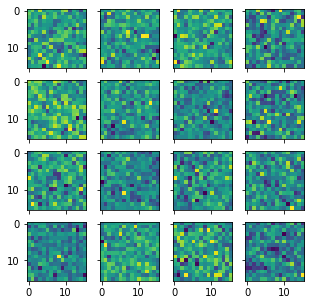

In [37]:
x, logq = apply_flow_to_prior(model['prior'], model['layers'], batch_size=16)

fig,axes = plt.subplots(4,4, figsize=(5,5), sharex=True, sharey=True)
for ax, x0 in zip(axes.ravel(),x):
    ax.imshow(grab(x0).squeeze().T, aspect='equal')
    ax.grid(False)
    

Now an important question to consider is what is the appropriate function $f$ in the normalizing flow that we sample that gets us to the right answer. 

Determining whether a model is a good fit for the target action is a challenging question to answer in general. However, one metric that can be used to assess model performance is the effective sample size (ESS) per configuration. In the following, we will be writing ESS but have in mind ESS per configuration.

ESS is defined on the interval $[0,1]$, and can be thought of as an effective percentage of configurations from the dataset generated from the target(fully correct) distribution that would yield the same statistics. This essentially like the efficiency of accepts when running a Markov chain sampler. For example, if a model generates 100 configurations with an ESS of 0.7, computing observables on these data would yield the same uncertainties as if you computed observables only on 70 configurations generated from the target distribution.

For MCMC, if we consider randomly sampled variables $X_{i}=\frac{p_{i}}{q_{i}}$ ie the random variable we sample to make the Markov Chain decision, we can write 

$$
\rm{ESS} = \frac{N}{1+2\sum_{i}{\rm Corr}(X_{i},X_{j})}
$$
Or in other words, if we have the correct distribution $p$ the our randomly sampled $x_{i}$ have no correlation. If they are correlated, we have a biased sampler. A little bit of math, will allow us to rewrite it in a convenient way for this problem. Here, If we have the predicted distribution $q$ and the true distribution $p$ we can write this as. 

$$
\frac{1}{\rm{ESS}} = \frac{\left(\sum_{i} \frac{p_{i}}{q_{i}}\right)^{2}}{N\sum_{i}\left( \frac{p_{i}}{q_{i}}\right)^{2}}\\
\frac{1}{\rm{ESS}} = \frac{1}{N}\exp\left(\log\left(\left(\sum_{i} \frac{p_{i}}{q_{i}}\right)^{2}\right) - \log\left(\sum_{i}\left( \frac{p_{i}}{q_{i}}\right)^{2}\right)\right)\\
$$

Which is what we compute below

In [38]:
def compute_ess(logp, logq):
    logw = logp - logq
    log_ess = 2*torch.logsumexp(logw, dim=0) - torch.logsumexp(2*logw, dim=0)
    ess_per_cfg = torch.exp(log_ess) / len(logw)
    return ess_per_cfg

### **Train the model**

For convenience, the cell below instantiates the model and everything we need to train it. We'll work with very small lattices with $L=4$ so training goes quickly.

In [39]:
# Lattice Theory
torch_device = 'cpu'#'cuda'
Lx, Lt = 16, 8
lattice_shape = (Lx,Lt)
M2 = -4.0
lam = 8.0

#kappa? 
#lam reparametrization here? 
phi4_action = ScalarPhi4Action(M2=M2, lam=lam)

# Model
prior = SimpleNormal(torch.zeros(lattice_shape, device=torch_device), torch.ones(lattice_shape, device=torch_device))

n_layers = 16
hidden_sizes = [8,8]
kernel_size = 3
layers = make_phi4_layers(
    lattice_shape=lattice_shape,
    n_layers=n_layers, 
    hidden_sizes=hidden_sizes,
    kernel_size=kernel_size
    ).to(torch_device)
model = {'layers': layers, 'prior': prior}

# Training
base_lr = 0.001
optimizer = torch.optim.Adam(model['layers'].parameters(), lr=base_lr)

We need to optimize the coupling layers to match the model distribution $q(\phi)$ to the target one $p(\phi)$. To do this, we minimize a quantity known as the Kullback-Leibler (KL) divergence, which measures the distance between two distributions. Training data drawn from $p$ can be scarce in simulations of lattice field theories, so we make use of the "reverse" KL divergence,
estimated using $N$ samples drawn from the model distribution ($\phi_i \sim q$) as
\begin{equation}
\widehat{D}_{KL}(q || p) = \frac{1}{N} \sum_{i=1}^N \left[ \log{q}(\phi_i) - \log{p}(\phi_i) \right] \quad \left( \phi_i \sim q \right).
\end{equation}

We use a "reverse KL self-training" protocol that consists of
  1. Drawing samples $\phi_i$ and density estimates $\log q(\phi_i)$ from the model
  2. Computing $\log p(\phi_i) \propto -S(\phi_i)$ on each sample
  3. Using $\log q$ and $\log p$ to compute the reverse KL divergence over the samples
  3. Using standard stochastic gradient descent methods (i.e. Adam) to iteratively update neural network weights
  
  
#### **Exercise: Training Normalizing flow model**
In this exercise, you will need to implement a training function by following the algorithm outlined above. During training, we collect statistics to monitor how the training is progressing. Our built-in function will use these statistics to plot a training figure.

In [40]:
def train_step(model, action, optimizer, metrics):
    layers, prior = model['layers'], model['prior']

    # code training
    x, logq = apply_flow_to_prior(prior, layers, batch_size=batch_size)
    logp = -action(x)
    loss = (logq - logp).mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    dkl = (logq - logp).mean()
    logw = logp - logq
    logZ = torch.logsumexp(logw, dim=0) - np.log(len(logw))
    metrics['dkl'].append(grab(dkl + logZ))
    
    # you will also need to add these metrics
    metrics['loss'].append(grab(loss))
    metrics['logp'].append(grab(logp))
    metrics['logq'].append(grab(logq))
    metrics['ess'].append(grab( compute_ess(logp, logq) ))

Finally, let's choose hyperparameters

In [41]:
N_era = 1
N_epoch = 200
batch_size = 1024 * 8
print_freq = 10
plot_freq = 1

history = {
    'loss' : [],
    'logp' : [],
    'logq' : [],
    'ess' : [],
    'dkl' : []
}

and run training

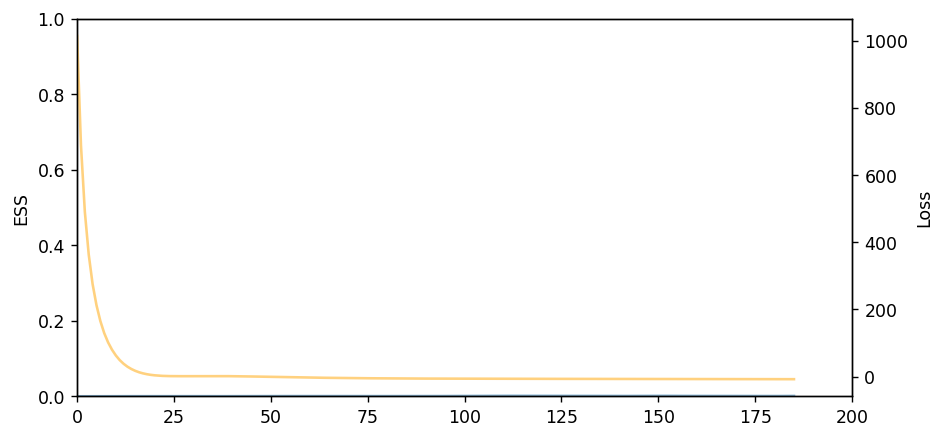

== Era 0 | Epoch 0 metrics ==
	loss 4950.02
	logp -5138.21
	logq -188.194
	ess 0.00012207
	dkl 3714.15
== Era 0 | Epoch 10 metrics ==
	loss 976.971
	logp -1110.37
	logq -133.396
	ess 0.000122929
	dkl 741.326
== Era 0 | Epoch 20 metrics ==
	loss 70.3524
	logp -140.806
	logq -70.454
	ess 0.000262833
	dkl 74.8536
== Era 0 | Epoch 30 metrics ==
	loss 3.76644
	logp -38.6827
	logq -34.9162
	ess 0.00059754
	dkl 16.2707
== Era 0 | Epoch 40 metrics ==
	loss 1.2264
	logp -19.5055
	logq -18.2791
	ess 0.000749005
	dkl 10.7367
== Era 0 | Epoch 50 metrics ==
	loss 1.49417
	logp -16.0742
	logq -14.58
	ess 0.000393417
	dkl 10.9955
== Era 0 | Epoch 60 metrics ==
	loss -0.480084
	logp -17.1214
	logq -17.6015
	ess 0.000812017
	dkl 9.96343
== Era 0 | Epoch 70 metrics ==
	loss -2.67239
	logp -19.6792
	logq -22.3516
	ess 0.000656486
	dkl 10.3448
== Era 0 | Epoch 80 metrics ==
	loss -4.23074
	logp -22.3112
	logq -26.5419
	ess 0.000803047
	dkl 9.80234
== Era 0 | Epoch 90 metrics ==
	loss -5.28078
	logp -24.38

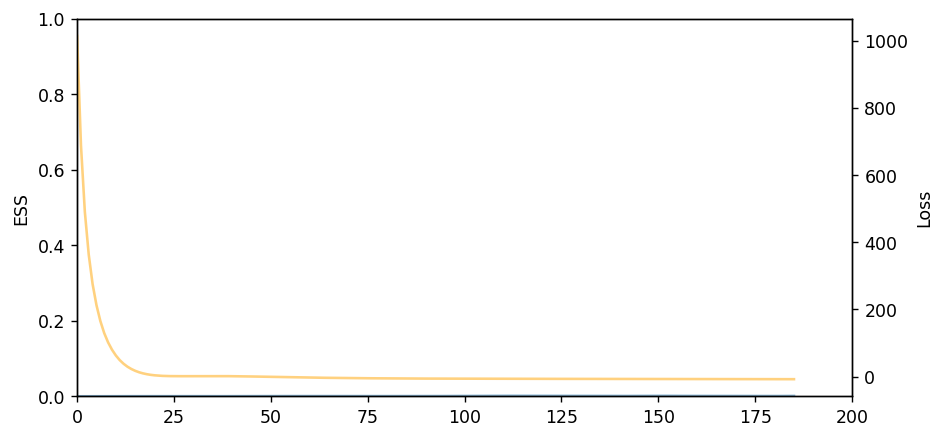

In [42]:

[plt.close(plt.figure(fignum)) for fignum in plt.get_fignums()] # close all existing figures
live_plot = init_live_plot()

for era in range(N_era):
    for epoch in range(N_epoch):
        train_step(model, phi4_action, optimizer, history)

        if epoch % print_freq == 0:
            print_metrics(history, avg_last_N_epochs=print_freq)

        if epoch % plot_freq == 0:
            update_plots(history, **live_plot)

The cell below draws a batch of configurations from the sample, computes $S(\phi)$ and $S_{\text{eff}} \equiv - \log q(\phi)$ on each one, then makes a 2d histogram comparing these quantities.

**Discuss:** What would this look like for a perfect model? How does your model compare?

slope 1 linear regression S = S_eff + -8.0128


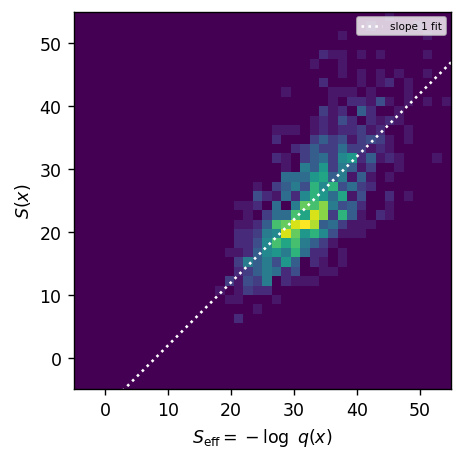

In [57]:
with torch.no_grad():
  phi, logq = apply_flow_to_prior(model['prior'], model['layers'], batch_size=1024)
S_eff = -grab(logq)
S = grab(phi4_action(phi))
fit_b = np.mean(S) - np.mean(S_eff)
print(f'slope 1 linear regression S = S_eff + {fit_b:.4f}')
fig, ax = plt.subplots(1,1, dpi=125, figsize=(4,4))
ax.hist2d(S_eff, S, bins=40, range=[[-5, 55], [-5, 55]])
ax.set_xlabel(r'$S_{\mathrm{eff}} = -\log~q(x)$')
ax.set_ylabel(r'$S(x)$')
ax.set_aspect('equal')
xs = np.linspace(-5, 55, num=4, endpoint=True)
ax.plot(xs, xs + fit_b, ':', color='w', label='slope 1 fit')
plt.legend(prop={'size': 6})
plt.show()

## Metropolis-Hastings algorithm


The Metropolis-Hastings algorithm is a Markov chain Monte Carlo (MCMC) method that generates samples for probability distributions when direct sampling is difficult or impossible. The algorithm constructs a sequence of configurations starting from an arbitrary configuration, with the sequence eventually following the target distribution. The algorithm can be summarized as follows:

1) Generate a new candidate configuration $\phi'$ from the previous configuration $\phi^{i-1}$ with a proposal probability $T(\phi^{i-1}\rightarrow \phi')$.

2) Accept the candidate configuration $\phi'$ as the new configuration $\phi^i$ with an acceptance probability:
\begin{equation}
p_{\mathrm{accept}}(\phi'|\phi^{i-1}) = \min \left(
1,
\frac{T(\phi' \rightarrow \phi^{i-1})}{T(\phi^{i-1} \rightarrow \phi')}
\frac{p(\phi')}{p(\phi^{i-1})}
\right),
\end{equation}
where $p(\phi)$ is the target probability density. If the suggested configuration is not accepted, the unchanged configuration is considered again in the sequence as $\phi^i = \phi^{i-1}$.

3) Repeat the steps to generate full ensemble.

It can be shown that samples generated with this algorithm are distributed according to the targeted probability density if $T(\phi^{i-1} \rightarrow \phi')$ is ergodic, meaning that there is a non-zero probability to generate all possible configurations $\phi'$.

### Metropolis algorithm for normalizing flow
To obtain **unbiased** estimates of observables, we can use the samples generated by our model as proposals in the Metropolis-Hastings (MH) algorithm. Using normalizing flows, we can assign a probability density $q(\phi)$ to each sample $\phi$, and this density can be used as the proposal probability in the MH algorithm. In this case, the acceptance probability takes the form:

\begin{equation}
p_{\mathrm{accept}}(\phi'|\phi^{i-1}) = \min \left(
1,
\frac{q(\phi^{i-1})}{q(\phi')}
\frac{p(\phi')}{p(\phi^{i-1})}
\right).
\end{equation}


To simplify the process, we create a function that generates and draws batches of samples from a flow model and then returns them one at a time, along with their respective $\log p$ and $\log q$ values. We can use each sample as a proposal in the MH algorithm.

In [44]:
def serial_sample_generator(model, action, batch_size, N_samples):
    layers, prior = model['layers'], model['prior']
    layers.eval()
    x, logq, logp = None, None, None
    with torch.no_grad():
      for i in range(N_samples):
          batch_i = i % batch_size
          if batch_i == 0:
              # we're out of samples to propose, generate a new batch
              x, logq = apply_flow_to_prior(prior, layers, batch_size=batch_size)
              logp = -action(x)
          yield x[batch_i], logq[batch_i], logp[batch_i]

If you are not familiar with Python generators, this function creates an object that you can iterate over, for example.

In [45]:
l = [phi.mean() for phi, _, _ in serial_sample_generator(model, phi4_action, 4, 6)]#vary the 6=> something what happens
print("Field values:", l)

Field values: [tensor(-0.0362), tensor(0.0040), tensor(-0.1009), tensor(-0.0743), tensor(-0.0712), tensor(-0.0505)]


#### **Exercise: Metroplis-Hastings for NF samples** 
Now we want you to setup the full Markov Chain MC sampling using everything you trained above! You are going to have to go up and follow things carefully, but its all here. An important point to consider is the serial step should be viewed as sequential Markov Chain Proposals. 

In this exercise, aka the function below, your goal is to create an MCMC ensemble using independent flow proposals and the acceptance probability formula we defined above. It's recommended to keep track of the history of some metrics, compute them, and add them to a dictionary. We will output the history later and use it to study the dynamics.

In [58]:
def make_mcmc_ensemble(model, action, batch_size, N_samples):
    # fill this history dict with values in MCMC ensemble
    history = {
        'x' : [],  # save configurations here
        'logq' : [],
        'logp' : [],
        'accepted' : []
    }

    # build Markov chain
    sample_gen = serial_sample_generator(model, action, batch_size, N_samples)
    for new_x, new_logq, new_logp in sample_gen:
        if len(history['logp']) == 0:
            # always accept first proposal, Markov chain must start somewhere
            accepted = True
        else: 
            last_logp = history['logp'][-1]
            last_logq = history['logq'][-1]
            
            p_accept = torch.exp((new_logp - new_logq) - (last_logp - last_logq))
            p_accept = min(1, p_accept)
            
            draw = torch.rand(1, device=new_x.device) # ~ [0,1]
            if draw < p_accept:
                accepted = True
            else:
                accepted = False
                new_x = history['x'][-1]
                new_logp = last_logp
                new_logq = last_logq
        # Update Markov chain
        history['logp'].append(new_logp)
        history['logq'].append(new_logq)
        history['x'].append(new_x)
        history['accepted'].append(accepted)
    return history

The Independence Metropolis acceptance rate is another metric to evaluate the quality of our model, similar to the ESS.

In [59]:
ensemble_size = 32*1024
phi4_ens = make_mcmc_ensemble(model, phi4_action, 1024, ensemble_size)
print("Accept rate:", np.mean(phi4_ens['accepted']))

Accept rate: 0.013275146484375


The NF model generates samples with a probability density `q(x)` that only approximates the target density `p(x)` to some degree. By applying the MH algorithm, we obtain samples that are distributed exactly according to the target density. The quality of the model's approximation can be evaluated using metrics such as ESS or acceptance rate, which we previously calculated.

Next, let's visualize the bias in "raw" sample or approximation error by plotting the distribution of the action of the theory. Note that bias in different observables could be different.

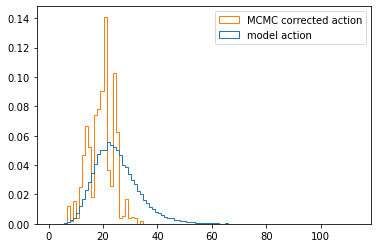

In [60]:
with torch.no_grad():
    phi, _ = apply_flow_to_prior(model['prior'], model['layers'], batch_size=ensemble_size)
phi_unbiased = torch.stack(phi4_ens['x'])

S, S_unbiased = map(lambda x: phi4_action(x).cpu(), [phi, phi_unbiased])
plt.hist(torch.stack([S, S_unbiased]), label=['model action', 'MCMC corrected action'], bins=100, density=1, histtype='step');
plt.legend();

### **Exercise (optional): training better model and examining approximation error**

The results obtained may vary depending on the quality of the model used. We encourage you to experiment with various hyperparameters, such as the CNN configuration, Adam parameters, and increasing the training duration to obtain better results. It is interesting to observe how the model samples approach the true samples as the model quality improves.

## Thermodynamics with Normalizing Flows (Not Optional...well) 
### Really, this is  The Ising on the cake! 

The thermodynamics of QCD has important implications for high-energy heavy-ion collision experiments, such as those performed at the Relativistic Heavy Ion Collider (RHIC) and the Large Hadron Collider (LHC). These experiments aim to recreate the conditions present in the early universe just after the Big Bang, and the study of QCD thermodynamics is essential for understanding the behavior of matter under these extreme conditions.

The thermodynamic properties of a system can be determined from the partition function
$$
Z(T,V) = \int \prod_{\vec{n}} d\phi(\vec{n}) ~ e^{-\frac{S(\phi)}{T}},
$$
where $V$ denotes the physical volume of the system and $T$ is temperature. In lattice QCD, one uses the MCMC method to generate configurations ${\phi}$ with probabilities proportional to $e^{-\frac{S(\phi)}{T}}$ and evaluate observables on these configurations. However, this method does not provide direct access to the normalizer of the probability density, $Z(T,V)$, making a study of thermodynamics a challenging problem.

Computation of patition function $Z(T,V)$ involves some approximations and tricks. Typically, these tricks rely on the fact that the ratio of partition functions  $Z(T,V)/Z(T_0,V)$ at different physical parameters $T$ and $T_0$ can be computed using samples without requiring constant normalizers. This ratio is then used to compute the partition function at the desired parameters. For instance, a possible approach would be to start from a known analytical value $Z (T_ 0, V)$. Next, one would execute MCMC simulations to compute $\frac{ Z(T,V)}{Z(T_ 0,V)}$. By combining these two results, one can obtain an interesting quantity $Z(T,V)=\frac{ Z(T,V)}{Z(T_ 0,V)} Z (T_ 0, C)$.

In practical simulations, the computation of the ratio of partition functions can be challenging due to the requirement of a good overlap of the probability densities corresponding to both partition functions in the ratio. The degree of overlap significantly decreases with changes in physical parameters, which means that the ratio can only be computed for closely related values. As a result, the interval of interest, say $[T, T_0]$, is split into a few small intervals where the overlap is good enough, and MCMC simulations are carried out for every value. This approach is computationally demanding, making the study of QCD thermodynamics a challenging problem.

Normalizing Flows provide an alternative approach. Comparing with conventional MCMC they not only generate samples $\phi$, but also provide the corresponding probability density. One can compute the partition function using the probability density provided by Normalizing Flows in a way similar to computing other observables.  This advantage allows the generation of **only one ensemble** of configurations and directly evaluates the partition function on it.  The new approach reduces the computational demand significantly and allows one to perform computations when the partition function is unknown for some base parameters.


In practical simulations, it is more common to calculate the Free Energy, which can be expressed as:
$$
F = - T \, \log Z,
$$
with $T$ being the absolute temperature. In lattice QCD with periodic boundary conditions tempreture can be expresses as $T = \frac{1}{L_t \, a}$.


### **Exercise**: Estimator of logZ

In this exercise, you will need to write an estimator for Partition function $Z$ using samples generated with probability density $q(\phi)$.

**Hint:** Start with definition of Parition function $Z$ and reweight integrand with density $q(\phi)$. After that you can use MC formula (aka average over all of $\phi$) to estimate the integral.

or more explicitly Recall : 

\begin{equation}
p(\phi) = \frac{1}{Z} e^{-S(\phi)}, \quad
Z \equiv \int \prod_{\vec{n}} d\phi(\vec{n}) ~ e^{-S(\phi)},
\end{equation}

and that $q(\phi)$ approximates $p$, then by averaging over all $\phi_{i}$ we get an esimate for $Z$ 


### Exercise - mini-project: Free energy computation with NF

For this mini-project, your task is to train a Normalizing Flow model and compute the free energy of scalar field theory for a specific set of physical parameters (mass and coupling). You will be able to compare your results with the values obtained in arXiv:2007.07115, which will enable you to verify your work. This project closely resembles a real scientific problem, essentially, you would just need to apply all skill you learned to action of interest. 

You will need:

1) Map action used in arXiv:2007.07115 to the action we used in this tutorial. Hopefully, you have already accomplished it in one of the previous exercises. We propose you to use physical parameters $\kappa=0.3$, $\lambda=0.022$ and lattice $L_t = 8$, $L_x=16$ as the smallest lattice from arXiv:2007.07115. **Hint:** when rescale ation do not forget to resacat $Z$ in a final formula.

2) Define a more expressive NF model and train it. It may require training it longer or even changing optimizer and/or optimizer hyperparameters.

3) Generate an ensemble of configurations using the MH algorithm as we did in previous sections.

4) Compute $Z$ using an estimator defined in a previous exercise. Compute free energy normalized by volume
$$
\frac{F}{V} a^2= \frac{1}{L_tL_x} \log \, Z
$$

**Hint:** Use `logsumexp` for numerical stability.

5) Estimate errors (This is Optional). Provide answers for free energy with uncertainties and compare your results with arXiv:2007.07115 Fig.2. **Hint:** Ensembles generated with MCMC often have large autocorrelations, which can result in underestimated uncertainties. Therefore, to estimate errors reliably, you can use various algorithms like  [binning](https://en.wikipedia.org/wiki/Data_binning#:~:text=Statistical%20data%20binning%20is%20a,grouping%20every%20five%20years%20together). For computing the uncertainty of a function of a random quantity, we suggest using the [bootstrap algorith](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html), or in otherword just taking mean and standard deviation by repeating the calculation removing some elements.  

